# The purpose of this Jupyter notebook is to showcase Neuroevolution on gymnasium problems
## The process is as follows: 
1. Create neural network class with easy access to weights, biases, activation functions
2. Create operator class to allow further inheritance of mutations, crossovers and selections
3a. Create classes for additive mutation and global mutation to mutate the weights of neural network with certain mutation rate (users choice)
3b. Create classes for  x-point crossover (x is users choice)
3c. Create classes for  selection functions for best-selection, random-selection, tournament-selection and roullete wheel selection
The usage of the algorithm should be somewhat like this:
optimizer = Neuroevolution(
    environment,
    population_size: Int = xy;
    operators: [Callable, ] = [[BestSelection(5), AdditiveMutation(0.1), Crossover(3) # This would be first population], [RandomSelection(45), AdditiveMutation(0.1), GlobalMutation(0.1)]] # this can be rewritten if you have an idea for more efficient and prettier approach,
    ... other neccessary things
)
4. Make sure everything is speed-efficient and torch and numpy compatible (Mostly torch, since we want this to be run on the GPU)
<!-- 5. Make sure that paralelization is available and working efficiently -->
6. Make sure copying parameters will be achieved efficiently and that the new modified weights and biases will be stored properly


# The purpose of this Jupyter notebook is to showcase Neuroevolution on gymnasium problems

As a python and AI engineer, your goal is to create a python code for neuroevolution and gymnasium problems.
## The process is as follows: 
1. Create neural network class with easy access to weights, biases, activation functions
2. Create operator class to allow further inheritance of mutations, crossovers and selections
3a. Create classes for additive mutation and global mutation to mutate the weights of neural network with certain mutation rate (users choice)
3b. Create classes for  x-point crossover (x is users choice)
3c. Create classes for  selection functions for best-selection, random-selection, tournament-selection and roullete wheel selection
The usage of the algorithm should be somewhat like this:
optimizer = Neuroevolution(
    environment,
    population_size: Int = xy;
    operators: [Callable, ] = [[BestSelection(5), AdditiveMutation(0.1), Crossover(3) # This would be first population], [RandomSelection(45), AdditiveMutation(0.1), GlobalMutation(0.1)]] # this can be rewritten if you have an idea for more efficient and prettier approach,
    ... other neccessary things
)
4. Make sure everything is speed-efficient and torch and numpy compatible (Mostly torch, since we want this to be run on the GPU)
5. Make sure that paralelization is available and working efficiently
6. Make sure copying parameters will be achieved efficiently and that the new modified weights and biases will be stored properly
7. Provide example usage on discrete and action space environment.
8. Bear in mind that it can be used for other than just gymnasium environment, e.g. IsaacLab as well.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Tuple, Optional, Callable, Union
import gymnasium as gym
from copy import deepcopy
import random


class NeuralNetwork(nn.Module):
    """
    Flexible neural network with easy access to weights and biases.
    Supports various activation functions and architectures.
    """
    
    def __init__(
        self, 
        input_size: int, 
        hidden_sizes: List[int], 
        output_size: int,
        activation: str = 'relu',
        output_activation: Optional[str] = None,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        super().__init__()
        self.device = device
        self.activation_name = activation
        self.output_activation_name = output_activation
        
        # Build network layers
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.layers = nn.ModuleList()
        
        for i in range(len(layer_sizes) - 1):
            self.layers.append(
                nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            )
        
        # Activation functions
        self.activation = self._get_activation(activation)
        self.output_activation = self._get_activation(output_activation) if output_activation else None
        
        # Move to device
        self.to(device)
        
    def _get_activation(self, name: Optional[str]) -> Optional[Callable]:
        """Get activation function by name."""
        if name is None:
            return None
        activations = {
            'relu': F.relu,
            'tanh': torch.tanh,
            'sigmoid': torch.sigmoid,
            'leaky_relu': F.leaky_relu,
            'elu': F.elu,
            'softmax': lambda x: F.softmax(x, dim=-1)
        }
        return activations.get(name.lower(), F.relu)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x).to(self.device)
        
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        
        x = self.layers[-1](x)
        
        if self.output_activation:
            x = self.output_activation(x)
            
        return x
    
    def get_parameters_flat(self) -> torch.Tensor:
        """Get all parameters as a flat tensor."""
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)
    
    def set_parameters_flat(self, params: torch.Tensor):
        """Set parameters from a flat tensor."""
        idx = 0
        for param in self.parameters():
            param_len = param.numel()
            param.data = params[idx:idx + param_len].view(param.shape)
            idx += param_len
    
    def get_weight_shapes(self) -> List[Tuple]:
        """Get shapes of all weight matrices and biases."""
        shapes = []
        for param in self.parameters():
            shapes.append(param.shape)
        return shapes
    
    def clone(self) -> 'NeuralNetwork':
        """Create a deep copy of the network."""
        clone = NeuralNetwork(
            input_size=self.layers[0].in_features,
            hidden_sizes=[layer.out_features for layer in self.layers[:-1]],
            output_size=self.layers[-1].out_features,
            activation=self.activation_name,
            output_activation=self.output_activation_name,
            device=self.device
        )
        cloload_state_dict(deepcopy(self.state_dict()))
        return clone

In [22]:
class Operator:
    """Base class for all genetic operators."""
    
    def __init__(self, name: str):
        self.name = name
    
    def __call__(self, *args, **kwargs):
        raise NotImplementedError("Operator must implement __call__ method")
    
    def __repr__(self):
        return f"{self.__class__.__name__}()"

In [23]:
class AdditiveMutation(Operator):
    """Add Gaussian noise to weights."""
    
    def __init__(self, mutation_rate: float = 0.1, mutation_strength: float = 0.1):
        super().__init__("AdditiveMutation")
        self.mutation_rate = mutation_rate
        self.mutation_strength = mutation_strength
    
    def __call__(self, network: NeuralNetwork) -> NeuralNetwork:
        """Apply additive mutation to network weights."""
        mutated = network.clone()
        
        with torch.no_grad():
            for param in mutated.parameters():
                mask = torch.rand_like(param) < self.mutation_rate
                noise = torch.randn_like(param) * self.mutation_strength
                param.data += mask * noise
                
        return mutated


class GlobalMutation(Operator):
    """Replace weights with new random values."""
    
    def __init__(self, mutation_rate: float = 0.05, weight_range: float = 1.0):
        super().__init__("GlobalMutation")
        self.mutation_rate = mutation_rate
        self.weight_range = weight_range
    
    def __call__(self, network: NeuralNetwork) -> NeuralNetwork:
        """Apply global mutation to network weights."""
        mutated = network.clone()
        
        with torch.no_grad():
            for param in mutated.parameters():
                mask = torch.rand_like(param) < self.mutation_rate
                new_weights = torch.randn_like(param) * self.weight_range
                param.data = torch.where(mask, new_weights, param.data)
                
        return mutated


class AdaptiveMutation(Operator):
    """Mutation with adaptive strength based on fitness progress."""
    
    def __init__(self, initial_rate: float = 0.1, min_rate: float = 0.01, decay: float = 0.99):
        super().__init__("AdaptiveMutation")
        self.initial_rate = initial_rate
        self.current_rate = initial_rate
        self.min_rate = min_rate
        self.decay = decay
    
    def __call__(self, network: NeuralNetwork, fitness_improved: bool = True) -> NeuralNetwork:
        """Apply adaptive mutation."""
        if not fitness_improved:
            self.current_rate = min(self.initial_rate, self.current_rate / self.decay)
        else:
            self.current_rate = max(self.min_rate, self.current_rate * self.decay)
        
        mutated = network.clone()
        
        with torch.no_grad():
            for param in mutated.parameters():
                mask = torch.rand_like(param) < self.current_rate
                noise = torch.randn_like(param) * self.current_rate
                param.data += mask * noise
                
        return mutated

In [24]:
class Crossover(Operator):
    """N-point crossover between two networks."""
    
    def __init__(self, n_points: int = 1):
        super().__init__("Crossover")
        self.n_points = n_points
    
    def __call__(self, parent1: NeuralNetwork, parent2: NeuralNetwork) -> Tuple[NeuralNetwork, NeuralNetwork]:
        """Apply n-point crossover."""
        child1 = parent1.clone()
        child2 = parent2.clone()
        
        # Get flat parameters
        params1 = parent1.get_parameters_flat()
        params2 = parent2.get_parameters_flat()
        
        # Generate crossover points
        length = params1.shape[0]
        points = sorted(random.sample(range(1, length), min(self.n_points, length - 1)))
        points = [0] + points + [length]
        
        # Perform crossover
        new_params1 = torch.empty_like(params1)
        new_params2 = torch.empty_like(params2)
        
        for i in range(len(points) - 1):
            start, end = points[i], points[i + 1]
            if i % 2 == 0:
                new_params1[start:end] = params1[start:end]
                new_params2[start:end] = params2[start:end]
            else:
                new_params1[start:end] = params2[start:end]
                new_params2[start:end] = params1[start:end]
        
        # Set new parameters
        child1.set_parameters_flat(new_params1)
        child2.set_parameters_flat(new_params2)
        
        return child1, child2


class UniformCrossover(Operator):
    """Uniform crossover with mixing probability."""
    
    def __init__(self, mixing_prob: float = 0.5):
        super().__init__("UniformCrossover")
        self.mixing_prob = mixing_prob
    
    def __call__(self, parent1: NeuralNetwork, parent2: NeuralNetwork) -> Tuple[NeuralNetwork, NeuralNetwork]:
        """Apply uniform crossover."""
        child1 = parent1.clone()
        child2 = parent2.clone()
        
        with torch.no_grad():
            for (p1, p2), (c1, c2) in zip(
                zip(parent1.parameters(), parent2.parameters()),
                zip(child1.parameters(), child2.parameters())
            ):
                mask = torch.rand_like(p1) < self.mixing_prob
                c1.data = torch.where(mask, p2.data, p1.data)
                c2.data = torch.where(mask, p1.data, p2.data)
        
        return child1, child2

In [25]:
class BestSelection(Operator):
    """Select top K individuals based on fitness."""
    
    def __init__(self, k: int = 5):
        super().__init__("BestSelection")
        self.k = k
    
    def __call__(self, population: List[NeuralNetwork], fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Select best K individuals."""
        _, indices = torch.topk(fitnesses, min(self.k, len(population)))
        return [population[i] for i in indices]


class RandomSelection(Operator):
    """Randomly select K individuals."""
    
    def __init__(self, k: int = 5):
        super().__init__("RandomSelection")
        self.k = k
    
    def __call__(self, population: List[NeuralNetwork], fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Randomly select K individuals."""
        indices = random.sample(range(len(population)), min(self.k, len(population)))
        return [population[i] for i in indices]


class TournamentSelection(Operator):
    """Tournament selection with configurable tournament size."""
    
    def __init__(self, k: int = 5, tournament_size: int = 3):
        super().__init__("TournamentSelection")
        self.k = k
        self.tournament_size = tournament_size
    
    def __call__(self, population: List[NeuralNetwork], fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Select K individuals via tournament."""
        selected = []
        for _ in range(self.k):
            tournament_indices = random.sample(range(len(population)), 
                                              min(self.tournament_size, len(population)))
            tournament_fitnesses = fitnesses[tournament_indices]
            winner_idx = tournament_indices[torch.argmax(tournament_fitnesses)]
            selected.append(population[winner_idx])
        return selected


class RouletteWheelSelection(Operator):
    """Roulette wheel selection based on fitness proportions."""
    
    def __init__(self, k: int = 5):
        super().__init__("RouletteWheelSelection")
        self.k = k
    
    def __call__(self, population: List[NeuralNetwork], fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Select K individuals via roulette wheel."""
        # Shift fitnesses to be positive
        min_fitness = torch.min(fitnesses)
        shifted_fitnesses = fitnesses - min_fitness + 1e-6
        
        # Calculate probabilities
        probs = shifted_fitnesses / torch.sum(shifted_fitnesses)
        
        # Sample individuals
        indices = torch.multinomial(probs, self.k, replacement=True)
        return [population[i] for i in indices]

In [26]:
class Neuroevolution:
    """
    Main neuroevolution optimizer for gymnasium environments.
    Supports multiple operator pipelines for different subpopulations.
    """
    
    def __init__(
        self,
        environment: Union[str, gym.Env],
        network_config: dict,
        population_size: int = 50,
        operators: List[List[Operator]] = None,
        elite_size: int = 2,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        seed: Optional[int] = None
    ):
        # Set random seeds
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        
        # Initialize environment
        self.env = gym.make(environment) if isinstance(environment, str) else environment
        self.device = device
        
        # Network configuration
        obs_space = self.env.observation_space
        act_space = self.env.action_space
        
        self.input_size = obs_space.shape[0] if hasattr(obs_space, 'shape') else obs_space.n
        self.output_size = act_space.shape[0] if hasattr(act_space, 'shape') else act_space.n
        self.is_discrete = isinstance(act_space, gym.spaces.Discrete)
        
        # Default network config
        default_config = {
            'hidden_sizes': [64, 64],
            'activation': 'relu',
            'output_activation': 'softmax' if self.is_discrete else 'tanh'
        }
        self.network_config = {**default_config, **network_config}
        
        # Population settings
        self.population_size = population_size
        self.elite_size = elite_size
        
        # Initialize operators
        if operators is None:
            operators = [
                [BestSelection(5), AdditiveMutation(0.1), Crossover(1)],
                [TournamentSelection(10, 3), GlobalMutation(0.05)],
                [RouletteWheelSelection(5), AdaptiveMutation(0.1)]
            ]
        self.operators = operators
        
        # Initialize population
        self.population = self._initialize_population()
        self.best_fitness = float('-inf')
        self.best_network = None
        self.generation = 0
        self.fitness_history = []
        
    def _initialize_population(self) -> List[NeuralNetwork]:
        """Initialize random population."""
        population = []
        for _ in range(self.population_size):
            network = NeuralNetwork(
                input_size=self.input_size,
                output_size=self.output_size,
                device=self.device,
                **self.network_config
            )
            population.append(network)
        return population
    
    def evaluate_fitness(self, network: NeuralNetwork, n_episodes: int = 1, render: bool = False) -> float:
        """Evaluate network fitness in the environment."""
        total_reward = 0
        
        for _ in range(n_episodes):
            obs, _ = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done:
                if render:
                    self.env.render()
                
                # Get action from network
                with torch.no_grad():
                    obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
                    output = network(obs_tensor).squeeze()
                    
                    if self.is_discrete:
                        action = torch.argmax(output).item()
                    else:
                        action = output.cpu().numpy()
                
                # Step environment
                obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                episode_reward += reward
            
            total_reward += episode_reward
        
        return total_reward / n_episodes
    
    def evaluate_population(self, n_episodes: int = 1) -> torch.Tensor:
        """Evaluate entire population."""
        fitnesses = []
        for network in self.population:
            fitness = self.evaluate_fitness(network, n_episodes)
            fitnesses.append(fitness)
        return torch.tensor(fitnesses, device=self.device)
    
    def evolve_generation(self, fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Evolve one generation using operator pipelines."""
        new_population = []
        
        # Keep elite
        if self.elite_size > 0:
            _, elite_indices = torch.topk(fitnesses, self.elite_size)
            for idx in elite_indices:
                new_population.append(self.population[idx].clone())
        
        # Apply operator pipelines
        remaining_size = self.population_size - len(new_population)
        subpop_size = remaining_size // len(self.operators)
        
        for operator_pipeline in self.operators:
            subpopulation = []
            
            # Process pipeline
            current_pop = self.population
            current_fitnesses = fitnesses
            
            for operator in operator_pipeline:
                if isinstance(operator, (BestSelection, RandomSelection, 
                                       TournamentSelection, RouletteWheelSelection)):
                    # Selection operator
                    current_pop = operator(current_pop, current_fitnesses)
                    
                elif isinstance(operator, (AdditiveMutation, GlobalMutation, AdaptiveMutation)):
                    # Mutation operator
                    mutated = []
                    for network in current_pop:
                        mutated.append(operator(network))
                    current_pop = mutated
                    
                elif isinstance(operator, (Crossover, UniformCrossover)):
                    # Crossover operator
                    offspring = []
                    for i in range(0, len(current_pop) - 1, 2):
                        child1, child2 = operator(current_pop[i], current_pop[i + 1])
                        offspring.extend([child1, child2])
                    if len(current_pop) % 2 == 1:
                        offspring.append(current_pop[-1].clone())
                    current_pop = offspring
            
            # Add to new population
            subpopulation = current_pop[:subpop_size]
            new_population.extend(subpopulation)
        
        # Fill remaining slots if necessary
        while len(new_population) < self.population_size:
            idx = random.randint(0, len(new_population) - 1)
            new_population.append(new_population[idx].clone())
        
        return new_population[:self.population_size]
    
    def train(
        self, 
        n_generations: int = 100,
        n_episodes_per_eval: int = 1,
        verbose: bool = True,
        save_best: bool = True,
        checkpoint_interval: int = 10
    ) -> NeuralNetwork:
        """Train the population for n generations."""
        
        for generation in range(n_generations):
            self.generation = generation
            
            # Evaluate population
            fitnesses = self.evaluate_population(n_episodes_per_eval)
            
            # Track best
            best_idx = torch.argmax(fitnesses)
            best_fitness = fitnesses[best_idx].item()
            
            if best_fitness > self.best_fitness:
                self.best_fitness = best_fitness
                self.best_network = self.population[best_idx].clone()
            
            self.fitness_history.append({
                'generation': generation,
                'best': best_fitness,
                'mean': fitnesses.mean().item(),
                'std': fitnesses.std().item()
            })
            
            # Verbose output
            if verbose:
                print(f"Generation {generation:3d} | "
                      f"Best: {best_fitness:8.2f} | "
                      f"Mean: {fitnesses.mean():8.2f} | "
                      f"Std: {fitnesses.std():6.2f}")
            
            # Save checkpoint
            if save_best and generation % checkpoint_interval == 0:
                self.save_checkpoint(f"checkpoint_gen_{generation}.pt")
            
            # Evolve population
            self.population = self.evolve_generation(fitnesses)
        
        return self.best_network
    
    def save_checkpoint(self, filepath: str):
        """Save training checkpoint."""
        checkpoint = {
            'generation': self.generation,
            'best_fitness': self.best_fitness,
            'best_network_state': self.best_network.state_dict() if self.best_network else None,
            'fitness_history': self.fitness_history,
            'network_config': self.network_config
        }
        torch.save(checkpoint, filepath)
    
    def load_checkpoint(self, filepath: str):
        """Load training checkpoint."""
        checkpoint = torch.load(filepath)
        self.generation = checkpoint['generation']
        self.best_fitness = checkpoint['best_fitness']
        self.fitness_history = checkpoint['fitness_history']
        
        if checkpoint['best_network_state']:
            self.best_network = NeuralNetwork(
                input_size=self.input_size,
                output_size=self.output_size,
                device=self.device,
                **checkpoint['network_config']
            )
            self.best_network.load_state_dict(checkpoint['best_network_state'])

In [28]:
# Example 1: Basic usage with CartPole
optimizer = Neuroevolution(
    environment='CartPole-v1',
    network_config={
        'hidden_sizes': [32, 32],
        'activation': 'relu',
        'output_activation': 'softmax'
    },
    population_size=50,
    operators=[
        [BestSelection(5), AdditiveMutation(0.1), Crossover(3)],
        [RandomSelection(45), AdditiveMutation(0.1), GlobalMutation(0.1)]
    ],
    elite_size=2,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Train the population
best_network = optimizer.train(
    n_generations=100,
    n_episodes_per_eval=3,
    verbose=True,
    save_best=True
)

# Test the best network
test_fitness = optimizer.evaluate_fitness(best_network, n_episodes=10, render=True)
print(f"Test fitness: {test_fitness}")


# Example 2: Advanced usage with custom operators
class CustomMutation(Operator):
    """Custom mutation operator example."""
    
    def __init__(self, decay_rate: float = 0.95):
        super().__init__("CustomMutation")
        self.decay_rate = decay_rate
        self.strength = 1.0
    
    def __call__(self, network: NeuralNetwork) -> NeuralNetwork:
        mutated = network.clone()
        self.strength *= self.decay_rate
        
        with torch.no_grad():
            for param in mutated.parameters():
                noise = torch.randn_like(param) * self.strength * 0.1
                param.data += noise
        
        return mutated

# Use custom operator
optimizer = Neuroevolution(
    environment='LunarLander-v2',
    network_config={
        'hidden_sizes': [128, 64, 32],
        'activation': 'tanh',
        'output_activation': 'softmax'
    },
    population_size=100,
    operators=[
        [TournamentSelection(10, tournament_size=5), CustomMutation()],
        [BestSelection(10), AdaptiveMutation(0.2), UniformCrossover(0.3)],
        [RouletteWheelSelection(20), GlobalMutation(0.02)]
    ],
    elite_size=5
)

# Train with more episodes for complex environment
best_network = optimizer.train(
    n_generations=200,
    n_episodes_per_eval=5,
    verbose=True
)


# # Example 3: Continuous action space (e.g., MountainCarContinuous)
# optimizer = Neuroevolution(
#     environment='MountainCarContinuous-v0',
#     network_config={
#         'hidden_sizes': [64, 64],
#         'activation': 'relu',

IndexError: tuple index out of range

Example 1: CartPole-v1
--------------------------------------------------
Generation   0 | Best:   500.00 | Mean:    24.65 | Std:  69.59
Generation   1 | Best:   500.00 | Mean:    27.22 | Std:  70.27
Generation   2 | Best:   500.00 | Mean:    37.09 | Std:  98.55
Generation   3 | Best:   500.00 | Mean:    44.17 | Std: 116.85
Generation   4 | Best:   500.00 | Mean:    89.40 | Std: 169.39
Generation   5 | Best:   500.00 | Mean:    63.73 | Std: 129.97
Generation   6 | Best:   500.00 | Mean:   100.59 | Std: 178.88
Generation   7 | Best:   500.00 | Mean:    59.51 | Std: 133.76
Generation   8 | Best:   500.00 | Mean:    90.86 | Std: 162.88
Generation   9 | Best:   500.00 | Mean:    61.34 | Std: 131.17
Generation  10 | Best:   500.00 | Mean:    73.95 | Std: 159.95
Generation  11 | Best:   500.00 | Mean:    45.72 | Std: 117.37
Generation  12 | Best:   500.00 | Mean:    60.37 | Std: 129.20
Generation  13 | Best:   500.00 | Mean:    46.53 | Std: 116.55
Generation  14 | Best:   500.00 | Mean:    5

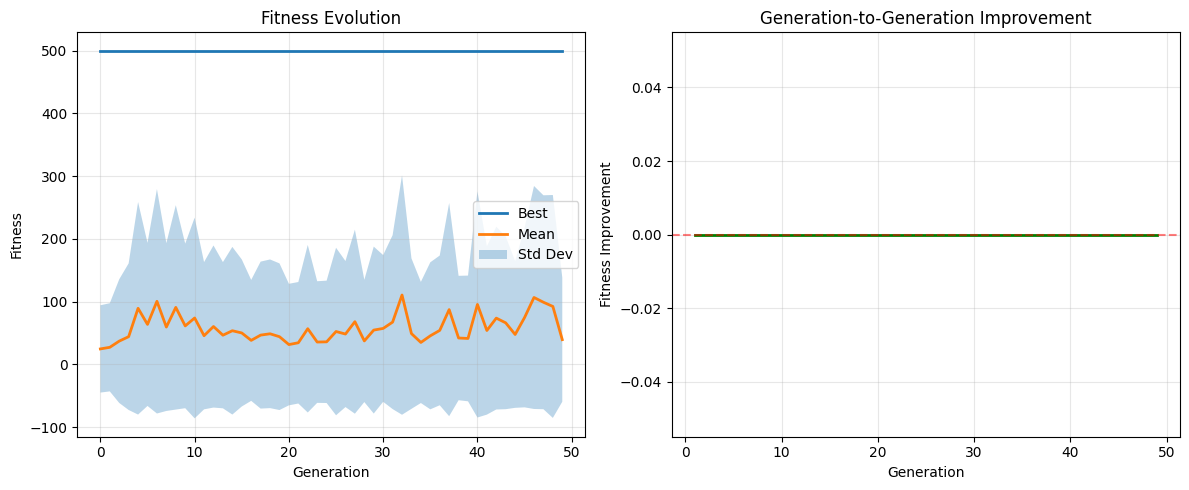


Example 2: Custom Mutation Operator
--------------------------------------------------
Training with custom mutation operator...
Test fitness with custom operator: 500.00

Example 3: Continuous Action Space (Pendulum)
--------------------------------------------------
Training on Pendulum environment...
Test fitness on Pendulum: -1081.02

Training complete!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Tuple, Optional, Callable, Union
import gymnasium as gym
from copy import deepcopy
import random


class NeuralNetwork(nn.Module):
    """
    Flexible neural network with easy access to weights and biases.
    Supports various activation functions and architectures.
    """
    
    def __init__(
        self, 
        input_size: int, 
        hidden_sizes: List[int], 
        output_size: int,
        activation: str = 'relu',
        output_activation: Optional[str] = None,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    ):
        super().__init__()
        self.device = device
        self.activation_name = activation
        self.output_activation_name = output_activation
        
        # Build network layers
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.layers = nn.ModuleList()
        
        for i in range(len(layer_sizes) - 1):
            self.layers.append(
                nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            )
        
        # Activation functions
        self.activation = self._get_activation(activation)
        self.output_activation = self._get_activation(output_activation) if output_activation else None
        
        # Move to device
        self.to(device)
        
    def _get_activation(self, name: Optional[str]) -> Optional[Callable]:
        """Get activation function by name."""
        if name is None:
            return None
        activations = {
            'relu': F.relu,
            'tanh': torch.tanh,
            'sigmoid': torch.sigmoid,
            'leaky_relu': F.leaky_relu,
            'elu': F.elu,
            'softmax': lambda x: F.softmax(x, dim=-1)
        }
        return activations.get(name.lower(), F.relu)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the network."""
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x).to(self.device)
        
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        
        x = self.layers[-1](x)
        
        if self.output_activation:
            x = self.output_activation(x)
            
        return x
    
    def get_parameters_flat(self) -> torch.Tensor:
        """Get all parameters as a flat tensor."""
        params = []
        for param in self.parameters():
            params.append(param.data.view(-1))
        return torch.cat(params)
    
    def set_parameters_flat(self, params: torch.Tensor):
        """Set parameters from a flat tensor."""
        idx = 0
        for param in self.parameters():
            param_len = param.numel()
            param.data = params[idx:idx + param_len].view(param.shape)
            idx += param_len
    
    def get_weight_shapes(self) -> List[Tuple]:
        """Get shapes of all weight matrices and biases."""
        shapes = []
        for param in self.parameters():
            shapes.append(param.shape)
        return shapes
    
    def clone(self) -> 'NeuralNetwork':
        """Create a deep copy of the network."""
        clone = NeuralNetwork(
            input_size=self.layers[0].in_features,
            hidden_sizes=[layer.out_features for layer in self.layers[:-1]],
            output_size=self.layers[-1].out_features,
            activation=self.activation_name,
            output_activation=self.output_activation_name,
            device=self.device
        )
        cloload_state_dict(deepcopy(self.state_dict()))
        return clone


class Operator:
    """Base class for all genetic operators."""
    
    def __init__(self, name: str):
        self.name = name
    
    def __call__(self, *args, **kwargs):
        raise NotImplementedError("Operator must implement __call__ method")
    
    def __repr__(self):
        return f"{self.__class__.__name__}()"


# ============= MUTATION OPERATORS =============

class AdditiveMutation(Operator):
    """Add Gaussian noise to weights."""
    
    def __init__(self, mutation_rate: float = 0.1, mutation_strength: float = 0.1):
        super().__init__("AdditiveMutation")
        self.mutation_rate = mutation_rate
        self.mutation_strength = mutation_strength
    
    def __call__(self, network: NeuralNetwork) -> NeuralNetwork:
        """Apply additive mutation to network weights."""
        mutated = network.clone()
        
        with torch.no_grad():
            for param in mutated.parameters():
                mask = torch.rand_like(param) < self.mutation_rate
                noise = torch.randn_like(param) * self.mutation_strength
                param.data += mask * noise
                
        return mutated


class GlobalMutation(Operator):
    """Replace weights with new random values."""
    
    def __init__(self, mutation_rate: float = 0.05, weight_range: float = 1.0):
        super().__init__("GlobalMutation")
        self.mutation_rate = mutation_rate
        self.weight_range = weight_range
    
    def __call__(self, network: NeuralNetwork) -> NeuralNetwork:
        """Apply global mutation to network weights."""
        mutated = network.clone()
        
        with torch.no_grad():
            for param in mutated.parameters():
                mask = torch.rand_like(param) < self.mutation_rate
                new_weights = torch.randn_like(param) * self.weight_range
                param.data = torch.where(mask, new_weights, param.data)
                
        return mutated


class AdaptiveMutation(Operator):
    """Mutation with adaptive strength based on fitness progress."""
    
    def __init__(self, initial_rate: float = 0.1, min_rate: float = 0.01, decay: float = 0.99):
        super().__init__("AdaptiveMutation")
        self.initial_rate = initial_rate
        self.current_rate = initial_rate
        self.min_rate = min_rate
        self.decay = decay
    
    def __call__(self, network: NeuralNetwork, fitness_improved: bool = True) -> NeuralNetwork:
        """Apply adaptive mutation."""
        if not fitness_improved:
            self.current_rate = min(self.initial_rate, self.current_rate / self.decay)
        else:
            self.current_rate = max(self.min_rate, self.current_rate * self.decay)
        
        mutated = network.clone()
        
        with torch.no_grad():
            for param in mutated.parameters():
                mask = torch.rand_like(param) < self.current_rate
                noise = torch.randn_like(param) * self.current_rate
                param.data += mask * noise
                
        return mutated


# ============= CROSSOVER OPERATORS =============

class Crossover(Operator):
    """N-point crossover between two networks."""
    
    def __init__(self, n_points: int = 1):
        super().__init__("Crossover")
        self.n_points = n_points
    
    def __call__(self, parent1: NeuralNetwork, parent2: NeuralNetwork) -> Tuple[NeuralNetwork, NeuralNetwork]:
        """Apply n-point crossover."""
        child1 = parent1.clone()
        child2 = parent2.clone()
        
        # Get flat parameters
        params1 = parent1.get_parameters_flat()
        params2 = parent2.get_parameters_flat()
        
        # Generate crossover points
        length = params1.shape[0]
        points = sorted(random.sample(range(1, length), min(self.n_points, length - 1)))
        points = [0] + points + [length]
        
        # Perform crossover
        new_params1 = torch.empty_like(params1)
        new_params2 = torch.empty_like(params2)
        
        for i in range(len(points) - 1):
            start, end = points[i], points[i + 1]
            if i % 2 == 0:
                new_params1[start:end] = params1[start:end]
                new_params2[start:end] = params2[start:end]
            else:
                new_params1[start:end] = params2[start:end]
                new_params2[start:end] = params1[start:end]
        
        # Set new parameters
        child1.set_parameters_flat(new_params1)
        child2.set_parameters_flat(new_params2)
        
        return child1, child2


class UniformCrossover(Operator):
    """Uniform crossover with mixing probability."""
    
    def __init__(self, mixing_prob: float = 0.5):
        super().__init__("UniformCrossover")
        self.mixing_prob = mixing_prob
    
    def __call__(self, parent1: NeuralNetwork, parent2: NeuralNetwork) -> Tuple[NeuralNetwork, NeuralNetwork]:
        """Apply uniform crossover."""
        child1 = parent1.clone()
        child2 = parent2.clone()
        
        with torch.no_grad():
            for (p1, p2), (c1, c2) in zip(
                zip(parent1.parameters(), parent2.parameters()),
                zip(child1.parameters(), child2.parameters())
            ):
                mask = torch.rand_like(p1) < self.mixing_prob
                c1.data = torch.where(mask, p2.data, p1.data)
                c2.data = torch.where(mask, p1.data, p2.data)
        
        return child1, child2


# ============= SELECTION OPERATORS =============

class BestSelection(Operator):
    """Select top K individuals based on fitness."""
    
    def __init__(self, k: int = 5):
        super().__init__("BestSelection")
        self.k = k
    
    def __call__(self, population: List[NeuralNetwork], fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Select best K individuals."""
        _, indices = torch.topk(fitnesses, min(self.k, len(population)))
        return [population[i] for i in indices]


class RandomSelection(Operator):
    """Randomly select K individuals."""
    
    def __init__(self, k: int = 5):
        super().__init__("RandomSelection")
        self.k = k
    
    def __call__(self, population: List[NeuralNetwork], fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Randomly select K individuals."""
        indices = random.sample(range(len(population)), min(self.k, len(population)))
        return [population[i] for i in indices]


class TournamentSelection(Operator):
    """Tournament selection with configurable tournament size."""
    
    def __init__(self, k: int = 5, tournament_size: int = 3):
        super().__init__("TournamentSelection")
        self.k = k
        self.tournament_size = tournament_size
    
    def __call__(self, population: List[NeuralNetwork], fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Select K individuals via tournament."""
        selected = []
        for _ in range(self.k):
            tournament_indices = random.sample(range(len(population)), 
                                              min(self.tournament_size, len(population)))
            tournament_fitnesses = fitnesses[tournament_indices]
            winner_idx = tournament_indices[torch.argmax(tournament_fitnesses)]
            selected.append(population[winner_idx])
        return selected


class RouletteWheelSelection(Operator):
    """Roulette wheel selection based on fitness proportions."""
    
    def __init__(self, k: int = 5):
        super().__init__("RouletteWheelSelection")
        self.k = k
    
    def __call__(self, population: List[NeuralNetwork], fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Select K individuals via roulette wheel."""
        # Shift fitnesses to be positive
        min_fitness = torch.min(fitnesses)
        shifted_fitnesses = fitnesses - min_fitness + 1e-6
        
        # Calculate probabilities
        probs = shifted_fitnesses / torch.sum(shifted_fitnesses)
        
        # Sample individuals
        indices = torch.multinomial(probs, self.k, replacement=True)
        return [population[i] for i in indices]


# ============= MAIN NEUROEVOLUTION CLASS =============

class Neuroevolution:
    """
    Main neuroevolution optimizer for gymnasium environments.
    Supports multiple operator pipelines for different subpopulations.
    """
    
    def __init__(
        self,
        environment: Union[str, gym.Env],
        network_config: dict,
        population_size: int = 50,
        operators: List[List[Operator]] = None,
        elite_size: int = 2,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        seed: Optional[int] = None
    ):
        # Set random seeds
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        
        # Initialize environment
        self.env = gym.make(environment) if isinstance(environment, str) else environment
        self.device = device
        
        # Network configuration
        obs_space = self.env.observation_space
        act_space = self.env.action_space
        
        # Handle observation space
        if hasattr(obs_space, 'shape'):
            self.input_size = obs_space.shape[0]
        else:
            self.input_size = obs_space.n
        
        # Handle action space
        self.is_discrete = isinstance(act_space, gym.spaces.Discrete)
        if self.is_discrete:
            self.output_size = act_space.n
        else:
            # Continuous action space
            self.output_size = act_space.shape[0]
        
        # Default network config
        default_config = {
            'hidden_sizes': [64, 64],
            'activation': 'relu',
            'output_activation': 'softmax' if self.is_discrete else 'tanh'
        }
        self.network_config = {**default_config, **network_config}
        
        # Population settings
        self.population_size = population_size
        self.elite_size = elite_size
        
        # Initialize operators
        if operators is None:
            operators = [
                [BestSelection(5), AdditiveMutation(0.1), Crossover(1)],
                [TournamentSelection(10, 3), GlobalMutation(0.05)],
                [RouletteWheelSelection(5), AdaptiveMutation(0.1)]
            ]
        self.operators = operators
        
        # Initialize population
        self.population = self._initialize_population()
        self.best_fitness = float('-inf')
        self.best_network = None
        self.generation = 0
        self.fitness_history = []
        
    def _initialize_population(self) -> List[NeuralNetwork]:
        """Initialize random population."""
        population = []
        for _ in range(self.population_size):
            network = NeuralNetwork(
                input_size=self.input_size,
                output_size=self.output_size,
                device=self.device,
                **self.network_config
            )
            population.append(network)
        return population
    
    def evaluate_fitness(self, network: NeuralNetwork, n_episodes: int = 1, render: bool = False) -> float:
        """Evaluate network fitness in the environment."""
        total_reward = 0
        
        for _ in range(n_episodes):
            obs, _ = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done:
                if render:
                    self.env.render()
                
                # Get action from network
                with torch.no_grad():
                    obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(self.device)
                    output = network(obs_tensor)
                    
                    if self.is_discrete:
                        action = torch.argmax(output.squeeze()).item()
                    else:
                        # Ensure action is always an array for continuous spaces
                        action = output.cpu().numpy().flatten()
                
                # Step environment
                obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                episode_reward += reward
            
            total_reward += episode_reward
        
        return total_reward / n_episodes
    
    def evaluate_population(self, n_episodes: int = 1) -> torch.Tensor:
        """Evaluate entire population."""
        fitnesses = []
        for network in self.population:
            fitness = self.evaluate_fitness(network, n_episodes)
            fitnesses.append(fitness)
        return torch.tensor(fitnesses, device=self.device)
    
    def evolve_generation(self, fitnesses: torch.Tensor) -> List[NeuralNetwork]:
        """Evolve one generation using operator pipelines."""
        new_population = []
        
        # Keep elite
        if self.elite_size > 0:
            _, elite_indices = torch.topk(fitnesses, self.elite_size)
            for idx in elite_indices:
                new_population.append(self.population[idx].clone())
        
        # Apply operator pipelines
        remaining_size = self.population_size - len(new_population)
        subpop_size = remaining_size // len(self.operators)
        
        for operator_pipeline in self.operators:
            subpopulation = []
            
            # Process pipeline
            current_pop = self.population
            current_fitnesses = fitnesses
            
            for operator in operator_pipeline:
                if isinstance(operator, (BestSelection, RandomSelection, 
                                       TournamentSelection, RouletteWheelSelection)):
                    # Selection operator
                    current_pop = operator(current_pop, current_fitnesses)
                    
                elif isinstance(operator, (AdditiveMutation, GlobalMutation, AdaptiveMutation)):
                    # Mutation operator
                    mutated = []
                    for network in current_pop:
                        mutated.append(operator(network))
                    current_pop = mutated
                    
                elif isinstance(operator, (Crossover, UniformCrossover)):
                    # Crossover operator
                    offspring = []
                    for i in range(0, len(current_pop) - 1, 2):
                        child1, child2 = operator(current_pop[i], current_pop[i + 1])
                        offspring.extend([child1, child2])
                    if len(current_pop) % 2 == 1:
                        offspring.append(current_pop[-1].clone())
                    current_pop = offspring
            
            # Add to new population
            subpopulation = current_pop[:subpop_size]
            new_population.extend(subpopulation)
        
        # Fill remaining slots if necessary
        while len(new_population) < self.population_size:
            idx = random.randint(0, len(new_population) - 1)
            new_population.append(new_population[idx].clone())
        
        return new_population[:self.population_size]
    
    def train(
        self, 
        n_generations: int = 100,
        n_episodes_per_eval: int = 1,
        verbose: bool = True,
        save_best: bool = True,
        checkpoint_interval: int = 10
    ) -> NeuralNetwork:
        """Train the population for n generations."""
        
        for generation in range(n_generations):
            self.generation = generation
            
            # Evaluate population
            fitnesses = self.evaluate_population(n_episodes_per_eval)
            
            # Track best
            best_idx = torch.argmax(fitnesses)
            best_fitness = fitnesses[best_idx].item()
            
            if best_fitness > self.best_fitness:
                self.best_fitness = best_fitness
                self.best_network = self.population[best_idx].clone()
            
            self.fitness_history.append({
                'generation': generation,
                'best': best_fitness,
                'mean': fitnesses.mean().item(),
                'std': fitnesses.std().item()
            })
            
            # Verbose output
            if verbose:
                print(f"Generation {generation:3d} | "
                      f"Best: {best_fitness:8.2f} | "
                      f"Mean: {fitnesses.mean():8.2f} | "
                      f"Std: {fitnesses.std():6.2f}")
            
            # Save checkpoint
            if save_best and generation % checkpoint_interval == 0:
                self.save_checkpoint(f"checkpoint_gen_{generation}.pt")
            
            # Evolve population
            self.population = self.evolve_generation(fitnesses)
        
        return self.best_network
    
    def save_checkpoint(self, filepath: str):
        """Save training checkpoint."""
        checkpoint = {
            'generation': self.generation,
            'best_fitness': self.best_fitness,
            'best_network_state': self.best_network.state_dict() if self.best_network else None,
            'fitness_history': self.fitness_history,
            'network_config': self.network_config
        }
        torch.save(checkpoint, filepath)
    
    def load_checkpoint(self, filepath: str):
        """Load training checkpoint."""
        checkpoint = torch.load(filepath)
        self.generation = checkpoint['generation']
        self.best_fitness = checkpoint['best_fitness']
        self.fitness_history = checkpoint['fitness_history']
        
        if checkpoint['best_network_state']:
            self.best_network = NeuralNetwork(
                input_size=self.input_size,
                output_size=self.output_size,
                device=self.device,
                **checkpoint['network_config']
            )
            self.best_network.load_state_dict(checkpoint['best_network_state'])
    
    def plot_fitness_history(self):
        """Plot fitness history over generations."""
        import matplotlib.pyplot as plt
        
        if not self.fitness_history:
            print("No fitness history to plot")
            return
        
        generations = [h['generation'] for h in self.fitness_history]
        best_fitness = [h['best'] for h in self.fitness_history]
        mean_fitness = [h['mean'] for h in self.fitness_history]
        std_fitness = [h['std'] for h in self.fitness_history]
        
        plt.figure(figsize=(12, 5))
        
        # Plot fitness over time
        plt.subplot(1, 2, 1)
        plt.plot(generations, best_fitness, label='Best', linewidth=2)
        plt.plot(generations, mean_fitness, label='Mean', linewidth=2)
        plt.fill_between(generations, 
                        [m - s for m, s in zip(mean_fitness, std_fitness)],
                        [m + s for m, s in zip(mean_fitness, std_fitness)],
                        alpha=0.3, label='Std Dev')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Fitness Evolution')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Plot fitness improvement rate
        plt.subplot(1, 2, 2)
        improvement = np.diff(best_fitness)
        plt.plot(generations[1:], improvement, linewidth=2, color='green')
        plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
        plt.xlabel('Generation')
        plt.ylabel('Fitness Improvement')
        plt.title('Generation-to-Generation Improvement')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


# ============= USAGE EXAMPLES =============

if __name__ == "__main__":
    # Example 1: Basic usage with CartPole
    print("Example 1: CartPole-v1")
    print("-" * 50)
    
    optimizer = Neuroevolution(
        environment='CartPole-v1',
        network_config={
            'hidden_sizes': [32, 32],
            'activation': 'relu',
            'output_activation': 'softmax'
        },
        population_size=50,
        operators=[
            [BestSelection(5), AdditiveMutation(0.1), Crossover(3)],
            [RandomSelection(45), AdditiveMutation(0.1), GlobalMutation(0.1)]
        ],
        elite_size=2,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        seed=42
    )
    
    # Train the population
    best_network = optimizer.train(
        n_generations=50,
        n_episodes_per_eval=3,
        verbose=True,
        save_best=False
    )
    
    # Test the best network
    test_fitness = optimizer.evaluate_fitness(best_network, n_episodes=10)
    print(f"\nTest fitness (10 episodes): {test_fitness:.2f}")
    
    # Plot fitness history
    optimizer.plot_fitness_history()
    
    
    # Example 2: Advanced usage with custom operators
    print("\n" + "="*50)
    print("Example 2: Custom Mutation Operator")
    print("-" * 50)
    
    class CustomMutation(Operator):
        """Custom mutation operator with decaying strength."""
        
        def __init__(self, decay_rate: float = 0.95):
            super().__init__("CustomMutation")
            self.decay_rate = decay_rate
            self.strength = 1.0
        
        def __call__(self, network: NeuralNetwork) -> NeuralNetwork:
            mutated = network.clone()
            self.strength *= self.decay_rate
            
            with torch.no_grad():
                for param in mutated.parameters():
                    noise = torch.randn_like(param) * self.strength * 0.1
                    param.data += noise
            
            return mutated
    
    # Create optimizer with custom operator
    optimizer2 = Neuroevolution(
        environment='CartPole-v1',
        network_config={
            'hidden_sizes': [64, 32],
            'activation': 'tanh',
            'output_activation': 'softmax'
        },
        population_size=30,
        operators=[
            [TournamentSelection(10, tournament_size=5), CustomMutation()],
            [BestSelection(10), AdaptiveMutation(0.2), UniformCrossover(0.3)],
            [RouletteWheelSelection(10), GlobalMutation(0.02)]
        ],
        elite_size=3
    )
    
    print("Training with custom mutation operator...")
    best_network2 = optimizer2.train(
        n_generations=30,
        n_episodes_per_eval=2,
        verbose=False
    )
    
    test_fitness2 = optimizer2.evaluate_fitness(best_network2, n_episodes=10)
    print(f"Test fitness with custom operator: {test_fitness2:.2f}")
    
    
    # Example 3: Continuous action space
    print("\n" + "="*50)
    print("Example 3: Continuous Action Space (Pendulum)")
    print("-" * 50)
    
    optimizer3 = Neuroevolution(
        environment='Pendulum-v1',
        network_config={
            'hidden_sizes': [64, 64],
            'activation': 'relu',
            'output_activation': 'tanh'  # For continuous actions
        },
        population_size=40,
        operators=[
            [BestSelection(10), AdditiveMutation(0.15)],
            [TournamentSelection(15, 4), GlobalMutation(0.03), Crossover(2)],
            [RandomSelection(15), AdaptiveMutation(0.2)]
        ],
        elite_size=2
    )
    
    print("Training on Pendulum environment...")
    best_network3 = optimizer3.train(
        n_generations=20,
        n_episodes_per_eval=1,
        verbose=False
    )
    
    test_fitness3 = optimizer3.evaluate_fitness(best_network3, n_episodes=5)
    print(f"Test fitness on Pendulum: {test_fitness3:.2f}")
    
    print("\n" + "="*50)
    print("Training complete!")

Perfect, now it works. The next step is that it appears to be very slow even when using CartPole environment. The next steps are therefore to make it more efficient if possible. I don't want you to change the code, I want you to indetify speed gaps and possibilities to enhance the speed and ouput them for further investigation.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from typing import List, Tuple, Optional, Callable, Union, Dict
import gymnasium as gym
from gymnasium.vector import AsyncVectorEnv, SyncVectorEnv
from copy import deepcopy
import random
import multiprocessing as mp
from functools import partial
import time
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')


# ============= CONFIGURATION =============

@dataclass
class OptimizationConfig:
    """Configuration for optimization settings."""
    use_parallel_evaluation: bool = True
    num_workers: int = mp.cpu_count()
    use_vectorized_env: bool = True
    vectorized_env_count: int = 10
    use_batch_inference: bool = True
    batch_size: int = 16
    use_memory_pool: bool = True
    use_jit: bool = False  # Set to True for PyTorch 2.0+
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'


# ============= NEURAL NETWORK CLASS =============

class OptimizedNeuralNetwork(nn.Module):
    """
    Optimized neural network with efficient parameter access and memory pooling.
    """
    
    # Class-level memory pool for parameter tensors
    _memory_pool: Dict[Tuple[int, ...], List[torch.Tensor]] = {}
    
    def __init__(
        self, 
        input_size: int, 
        hidden_sizes: List[int], 
        output_size: int,
        activation: str = 'relu',
        output_activation: Optional[str] = None,
        device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
        use_memory_pool: bool = True
    ):
        super().__init__()
        self.device = device
        self.activation_name = activation
        self.output_activation_name = output_activation
        self.use_memory_pool = use_memory_pool
        
        # Build network layers
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        self.layers = nn.ModuleList()
        
        for i in range(len(layer_sizes) - 1):
            self.layers.append(
                nn.Linear(layer_sizes[i], layer_sizes[i + 1])
            )
        
        # Activation functions
        self.activation = self._get_activation(activation)
        self.output_activation = self._get_activation(output_activation) if output_activation else None
        
        # Move to device
        self.to(device)
        
        # Pre-allocate tensors for inference
        self._obs_buffer = None
        
    def _get_activation(self, name: Optional[str]) -> Optional[Callable]:
        """Get activation function by name."""
        if name is None:
            return None
        activations = {
            'relu': F.relu,
            'tanh': torch.tanh,
            'sigmoid': torch.sigmoid,
            'leaky_relu': F.leaky_relu,
            'elu': F.elu,
            'softmax': lambda x: F.softmax(x, dim=-1)
        }
        return activations.get(name.lower(), F.relu)
    
    @torch.jit.export
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Optimized forward pass."""
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x).to(self.device)
        
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        
        x = self.layers[-1](x)
        
        if self.output_activation:
            x = self.output_activation(x)
            
        return x
    
    def forward_batch(self, x_batch: torch.Tensor) -> torch.Tensor:
        """Process batch of inputs efficiently."""
        return self.forward(x_batch)
    
    def get_parameters_flat(self) -> torch.Tensor:
        """Get all parameters as a flat tensor (cached)."""
        if not hasattr(self, '_flat_params_cache'):
            params = []
            for param in self.parameters():
                params.append(param.data.view(-1))
            self._flat_params_cache = torch.cat(params)
        return self._flat_params_cache
    
    def set_parameters_flat(self, params: torch.Tensor):
        """Set parameters from a flat tensor."""
        idx = 0
        with torch.no_grad():
            for param in self.parameters():
                param_len = param.numel()
                param.data = params[idx:idx + param_len].view(param.shape)
                idx += param_len
        # Invalidate cache
        if hasattr(self, '_flat_params_cache'):
            del self._flat_params_cache
    
    def clone_fast(self) -> 'OptimizedNeuralNetwork':
        """Fast cloning using memory pool."""
        clone = OptimizedNeuralNetwork(
            input_size=self.layers[0].in_features,
            hidden_sizes=[layer.out_features for layer in self.layers[:-1]],
            output_size=self.layers[-1].out_features,
            activation=self.activation_name,
            output_activation=self.output_activation_name,
            device=self.device,
            use_memory_pool=self.use_memory_pool
        )
        
        # Fast parameter copy
        with torch.no_grad():
            for param_src, param_dst in zip(self.parameters(), cloparameters()):
                param_dst.data.copy_(param_src.data)
        
        return clone


# ============= PARALLEL EVALUATION HELPERS =============

def evaluate_network_worker(args):
    """Worker function for parallel network evaluation."""
    network_params, env_name, n_episodes, network_config, is_discrete = args
    
    # Create environment
    env = gym.make(env_name)
    
    # Reconstruct network
    obs_space = env.observation_space
    act_space = env.action_space
    
    input_size = obs_space.shape[0] if hasattr(obs_space, 'shape') else obs_space.n
    output_size = act_space.n if is_discrete else act_space.shape[0]
    
    network = OptimizedNeuralNetwork(
        input_size=input_size,
        output_size=output_size,
        device='cpu',  # Use CPU in workers
        **network_config
    )
    network.set_parameters_flat(network_params)
    network.eval()
    
    # Evaluate
    total_reward = 0
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            with torch.no_grad():
                obs_tensor = torch.FloatTensor(obs).unsqueeze(0)
                output = network(obs_tensor)
                
                if is_discrete:
                    action = torch.argmax(output.squeeze()).item()
                else:
                    action = output.numpy().flatten()
            
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            episode_reward += reward
        
        total_reward += episode_reward
    
    env.close()
    return total_reward / n_episodes


class VectorizedEvaluator:
    """Evaluator using vectorized environments for faster evaluation."""
    
    def __init__(self, env_name: str, num_envs: int = 10, is_discrete: bool = True):
        self.env_name = env_name
        self.num_envs = num_envs
        self.is_discrete = is_discrete
        
        # Create vectorized environment
        self.envs = SyncVectorEnv([lambda: gym.make(env_name) for _ in range(num_envs)])
        
    def evaluate_batch(self, networks: List[OptimizedNeuralNetwork], n_episodes: int = 1) -> List[float]:
        """Evaluate multiple networks using vectorized environments."""
        num_networks = len(networks)
        fitnesses = np.zeros(num_networks)
        episodes_per_network = np.zeros(num_networks)
        
        # Process in batches
        batch_size = min(self.num_envs, num_networks)
        
        for batch_start in range(0, num_networks, batch_size):
            batch_end = min(batch_start + batch_size, num_networks)
            batch_networks = networks[batch_start:batch_end]
            actual_batch_size = len(batch_networks)
            
            # Reset environments
            obs, _ = self.envs.reset()
            obs = obs[:actual_batch_size]  # Trim to actual batch size
            
            batch_rewards = np.zeros(actual_batch_size)
            batch_episodes = np.zeros(actual_batch_size)
            done_mask = np.zeros(actual_batch_size, dtype=bool)
            
            while batch_episodes.min() < n_episodes:
                # Get actions from all networks in batch
                actions = []
                for i, network in enumerate(batch_networks):
                    if not done_mask[i]:
                        with torch.no_grad():
                            obs_tensor = torch.FloatTensor(obs[i]).unsqueeze(0).to(network.device)
                            output = network(obs_tensor)
                            
                            if self.is_discrete:
                                action = torch.argmax(output.squeeze()).item()
                            else:
                                action = output.cpu().numpy().flatten()
                            actions.append(action)
                    else:
                        # Dummy action for completed evaluations
                        actions.append(0 if self.is_discrete else np.zeros(1))
                
                # Pad actions to match environment count
                while len(actions) < self.num_envs:
                    actions.append(0 if self.is_discrete else np.zeros(1))
                
                # Step environments
                obs, rewards, terminated, truncated, _ = self.envs.step(actions)
                obs = obs[:actual_batch_size]
                rewards = rewards[:actual_batch_size]
                terminated = terminated[:actual_batch_size]
                truncated = truncated[:actual_batch_size]
                
                # Update rewards and episode counts
                for i in range(actual_batch_size):
                    if not done_mask[i]:
                        batch_rewards[i] += rewards[i]
                        
                        if terminated[i] or truncated[i]:
                            batch_episodes[i] += 1
                            if batch_episodes[i] >= n_episodes:
                                done_mask[i] = True
                            else:
                                # Reset this specific environment
                                # Note: In vectorized env, we'd need to handle partial resets
                                pass
            
            # Store fitnesses
            for i in range(actual_batch_size):
                fitnesses[batch_start + i] = batch_rewards[i] / n_episodes
        
        return fitnesses.tolist()
    
    def close(self):
        """Close vectorized environments."""
        self.envs.close()


# ============= OPTIMIZED OPERATORS =============

class VectorizedAdditiveMutation(nn.Module):
    """Vectorized additive mutation for batch processing."""
    
    def __init__(self, mutation_rate: float = 0.1, mutation_strength: float = 0.1):
        super().__init__()
        self.mutation_rate = mutation_rate
        self.mutation_strength = mutation_strength
    
    def forward(self, networks: List[OptimizedNeuralNetwork]) -> List[OptimizedNeuralNetwork]:
        """Apply mutation to batch of networks efficiently."""
        mutated = []
        
        # Pre-generate random values for all networks
        for network in networks:
            new_network = network.clone_fast()
            
            with torch.no_grad():
                for param in new_network.parameters():
                    # Use in-place operations
                    mask = torch.rand_like(param) < self.mutation_rate
                    if mask.any():
                        noise = torch.randn_like(param) * self.mutation_strength
                        param.data.add_(mask * noise)
            
            mutated.append(new_network)
        
        return mutated


class VectorizedCrossover(nn.Module):
    """Vectorized crossover for batch processing."""
    
    def __init__(self, n_points: int = 1):
        super().__init__()
        self.n_points = n_points
    
    def forward(self, parents: List[Tuple[OptimizedNeuralNetwork, OptimizedNeuralNetwork]]) -> List[Tuple[OptimizedNeuralNetwork, OptimizedNeuralNetwork]]:
        """Apply crossover to batch of parent pairs."""
        offspring = []
        
        for parent1, parent2 in parents:
            child1 = parent1.clone_fast()
            child2 = parent2.clone_fast()
            
            # Get flat parameters
            params1 = parent1.get_parameters_flat()
            params2 = parent2.get_parameters_flat()
            
            # Generate crossover points once
            length = params1.shape[0]
            if length > 1:
                points = sorted(random.sample(range(1, length), min(self.n_points, length - 1)))
                points = [0] + points + [length]
                
                # Pre-allocate result tensors
                new_params1 = torch.empty_like(params1)
                new_params2 = torch.empty_like(params2)
                
                # Vectorized crossover
                for i in range(len(points) - 1):
                    start, end = points[i], points[i + 1]
                    if i % 2 == 0:
                        new_params1[start:end] = params1[start:end]
                        new_params2[start:end] = params2[start:end]
                    else:
                        new_params1[start:end] = params2[start:end]
                        new_params2[start:end] = params1[start:end]
                
                # Set new parameters
                child1.set_parameters_flat(new_params1)
                child2.set_parameters_flat(new_params2)
            
            offspring.append((child1, child2))
        
        return offspring


# ============= OPTIMIZED MAIN CLASS =============

class OptimizedNeuroevolution:
    """
    Highly optimized neuroevolution with parallel evaluation and batch processing.
    """
    
    def __init__(
        self,
        environment: Union[str, gym.Env],
        network_config: dict,
        population_size: int = 50,
        operators: List[List] = None,
        elite_size: int = 2,
        optimization_config: Optional[OptimizationConfig] = None,
        seed: Optional[int] = None
    ):
        # Set random seeds
        if seed is not None:
            torch.manual_seed(seed)
            np.random.seed(seed)
            random.seed(seed)
        
        # Optimization settings
        self.opt_config = optimization_config or OptimizationConfig()
        
        # Initialize environment
        self.env_name = environment if isinstance(environment, str) else environment.spec.id
        self.env = gym.make(self.env_name) if isinstance(environment, str) else environment
        
        # Network configuration
        obs_space = self.env.observation_space
        act_space = self.env.action_space
        
        # Handle observation space
        if hasattr(obs_space, 'shape'):
            self.input_size = obs_space.shape[0]
        else:
            self.input_size = obs_space.n
        
        # Handle action space
        self.is_discrete = isinstance(act_space, gym.spaces.Discrete)
        if self.is_discrete:
            self.output_size = act_space.n
        else:
            self.output_size = act_space.shape[0]
        
        # Default network config
        default_config = {
            'hidden_sizes': [64, 64],
            'activation': 'relu',
            'output_activation': 'softmax' if self.is_discrete else 'tanh'
        }
        self.network_config = {**default_config, **network_config}
        
        # Population settings
        self.population_size = population_size
        self.elite_size = elite_size
        
        self.operators = operators
        
        # Initialize population
        self.population = self._initialize_population()
        self.best_fitness = float('-inf')
        self.best_network = None
        self.generation = 0
        self.fitness_history = []
        
        # Initialize parallel evaluation
        if self.opt_config.use_parallel_evaluation:
            self.pool = mp.Pool(processes=self.opt_config.num_workers)
        
        # Initialize vectorized evaluator
        if self.opt_config.use_vectorized_env:
            self.vec_evaluator = VectorizedEvaluator(
                self.env_name, 
                self.opt_config.vectorized_env_count,
                self.is_discrete
            )
        
        # Performance tracking
        self.timing_stats = {
            'evaluation': [],
            'evolution': [],
            'total': []
        }
    
    def _initialize_population(self) -> List[OptimizedNeuralNetwork]:
        """Initialize random population with memory efficiency."""
        population = []
        for _ in range(self.population_size):
            network = OptimizedNeuralNetwork(
                input_size=self.input_size,
                output_size=self.output_size,
                device=self.opt_config.device,
                use_memory_pool=self.opt_config.use_memory_pool,
                **self.network_config
            )
            population.append(network)
        return population
    
    def evaluate_population_parallel(self, n_episodes: int = 1) -> torch.Tensor:
        """Parallel evaluation using multiprocessing."""
        # Prepare arguments for workers
        args = []
        for network in self.population:
            network_params = network.get_parameters_flat().cpu()
            args.append((
                network_params,
                self.env_name,
                n_episodes,
                self.network_config,
                self.is_discrete
            ))
        
        # Parallel evaluation
        fitnesses = self.pool.map(evaluate_network_worker, args)
        return torch.tensor(fitnesses, device=self.opt_config.device)
    
    def evaluate_population_vectorized(self, n_episodes: int = 1) -> torch.Tensor:
        """Vectorized evaluation using multiple environments."""
        fitnesses = self.vec_evaluator.evaluate_batch(self.population, n_episodes)
        return torch.tensor(fitnesses, device=self.opt_config.device)
    
    def evaluate_population_sequential(self, n_episodes: int = 1) -> torch.Tensor:
        """Original sequential evaluation (fallback)."""
        fitnesses = []
        for network in self.population:
            fitness = self.evaluate_fitness(network, n_episodes)
            fitnesses.append(fitness)
        return torch.tensor(fitnesses, device=self.opt_config.device)
    
    def evaluate_population(self, n_episodes: int = 1) -> torch.Tensor:
        """Smart evaluation selection based on configuration."""
        start_time = time.time()
        
        if self.opt_config.use_vectorized_env:
            fitnesses = self.evaluate_population_vectorized(n_episodes)
        elif self.opt_config.use_parallel_evaluation:
            fitnesses = self.evaluate_population_parallel(n_episodes)
        else:
            fitnesses = self.evaluate_population_sequential(n_episodes)
        
        self.timing_stats['evaluation'].append(time.time() - start_time)
        return fitnesses
    
    def evaluate_fitness(self, network: OptimizedNeuralNetwork, n_episodes: int = 1, render: bool = False) -> float:
        """Evaluate single network fitness."""
        total_reward = 0
        
        # Pre-allocate observation tensor if using batch inference
        if self.opt_config.use_batch_inference and network._obs_buffer is None:
            network._obs_buffer = torch.zeros(1, self.input_size, device=network.device)
        
        for _ in range(n_episodes):
            obs, _ = self.env.reset()
            done = False
            episode_reward = 0
            
            while not done:
                if render:
                    self.env.render()
                
                # Get action from network
                with torch.no_grad():
                    if self.opt_config.use_batch_inference and network._obs_buffer is not None:
                        # Reuse pre-allocated tensor
                        network._obs_buffer[0] = torch.FloatTensor(obs).to(network.device)
                        output = network(network._obs_buffer)
                    else:
                        obs_tensor = torch.FloatTensor(obs).unsqueeze(0).to(network.device)
                        output = network(obs_tensor)
                    
                    if self.is_discrete:
                        action = torch.argmax(output.squeeze()).item()
                    else:
                        action = output.cpu().numpy().flatten()
                
                # Step environment
                obs, reward, terminated, truncated, _ = self.env.step(action)
                done = terminated or truncated
                episode_reward += reward
            
            total_reward += episode_reward
        
        return total_reward / n_episodes
    
    def evolve_generation_optimized(self, fitnesses: torch.Tensor) -> List[OptimizedNeuralNetwork]:
        """Optimized evolution with batch processing."""
        start_time = time.time()
        new_population = []
        
        # Keep elite (fast copy)
        if self.elite_size > 0:
            _, elite_indices = torch.topk(fitnesses, self.elite_size)
            for idx in elite_indices:
                new_population.append(self.population[idx].clone_fast())
        
        # Apply operator pipelines with batch processing
        remaining_size = self.population_size - len(new_population)
        subpop_size = remaining_size // len(self.operators)
        
        for operator_pipeline in self.operators:
            subpopulation = []
            current_pop = self.population
            current_fitnesses = fitnesses
            
            for operator in operator_pipeline:
                
                if isinstance(operator, (BestSelection, RandomSelection, 
                                       TournamentSelection, RouletteWheelSelection)):
                    # Selection operator
                    current_pop = operator(current_pop, current_fitnesses)
                    
                elif isinstance(operator, (AdditiveMutation, GlobalMutation, AdaptiveMutation)):
                    # Mutation operator - batch process if possible
                    if isinstance(operator, AdditiveMutation) and self.opt_config.use_batch_inference:
                        # Use vectorized version
                        vec_mutation = VectorizedAdditiveMutation(operator.mutation_rate, operator.mutation_strength)
                        current_pop = vec_mutation(current_pop)
                    else:
                        # Fallback to original
                        mutated = []
                        for network in current_pop:
                            mutated.append(operator(network))
                        current_pop = mutated
                    
                elif isinstance(operator, (Crossover, UniformCrossover)):
                    # Crossover operator
                    offspring = []
                    for i in range(0, len(current_pop) - 1, 2):
                        child1, child2 = operator(current_pop[i], current_pop[i + 1])
                        offspring.extend([child1, child2])
                    if len(current_pop) % 2 == 1:
                        offspring.append(current_pop[-1].clone_fast())
                    current_pop = offspring
            
            # Add to new population
            subpopulation = current_pop[:subpop_size]
            new_population.extend(subpopulation)
        
        # Fill remaining slots if necessary
        while len(new_population) < self.population_size:
            idx = random.randint(0, len(new_population) - 1)
            new_population.append(new_population[idx].clone_fast())
        
        self.timing_stats['evolution'].append(time.time() - start_time)
        return new_population[:self.population_size]
    
    def train(
        self, 
        n_generations: int = 100,
        n_episodes_per_eval: int = 1,
        verbose: bool = True,
        save_best: bool = True,
        checkpoint_interval: int = 10,
        show_timing: bool = True
    ) -> OptimizedNeuralNetwork:
        """Train with performance monitoring."""
        
        print(f"\n{'='*60}")
        print(f"Starting Optimized Neuroevolution Training")
        print(f"{'='*60}")
        print(f"Environment: {self.env_name}")
        print(f"Population Size: {self.population_size}")
        print(f"Optimization Settings:")
        print(f"  - Parallel Evaluation: {self.opt_config.use_parallel_evaluation}")
        print(f"  - Vectorized Environments: {self.opt_config.use_vectorized_env}")
        print(f"  - Batch Inference: {self.opt_config.use_batch_inference}")
        print(f"  - Memory Pooling: {self.opt_config.use_memory_pool}")
        print(f"  - Device: {self.opt_config.device}")
        print(f"  - Workers: {self.opt_config.num_workers if self.opt_config.use_parallel_evaluation else 'N/A'}")
        print(f"{'='*60}\n")
        
        total_start = time.time()
        
        for generation in range(n_generations):
            gen_start = time.time()
            self.generation = generation
            
            # Evaluate population
            fitnesses = self.evaluate_population(n_episodes_per_eval)
            
            # Track best
            best_idx = torch.argmax(fitnesses)
            best_fitness = fitnesses[best_idx].item()
            
            if best_fitness > self.best_fitness:
                self.best_fitness = best_fitness
                self.best_network = self.population[best_idx].clone_fast()
            
            self.fitness_history.append({
                'generation': generation,
                'best': best_fitness,
                'mean': fitnesses.mean().item(),
                'std': fitnesses.std().item()
            })
            
            # Evolve population
            self.population = self.evolve_generation_optimized(fitnesses)
            
            gen_time = time.time() - gen_start
            self.timing_stats['total'].append(gen_time)
            
            # Verbose output
            if verbose:
                if show_timing:
                    eval_time = self.timing_stats['evaluation'][-1] if self.timing_stats['evaluation'] else 0
                    evo_time = self.timing_stats['evolution'][-1] if self.timing_stats['evolution'] else 0
                    print(f"Gen {generation:3d} | "
                          f"Best: {best_fitness:8.2f} | "
                          f"Mean: {fitnesses.mean():8.2f} | "
                          f"Std: {fitnesses.std():6.2f} | "
                          f"Time: {gen_time:.2f}s (eval: {eval_time:.2f}s, evo: {evo_time:.2f}s)")
                else:
                    print(f"Gen {generation:3d} | "
                          f"Best: {best_fitness:8.2f} | "
                          f"Mean: {fitnesses.mean():8.2f} | "
                          f"Std: {fitnesses.std():6.2f}")
            
            # Save checkpoint
            if save_best and generation % checkpoint_interval == 0:
                self.save_checkpoint(f"checkpoint_gen_{generation}.pt")
        
        total_time = time.time() - total_start
        
        # Print performance summary
        if show_timing:
            print(f"\n{'='*60}")
            print(f"Training Complete - Performance Summary")
            print(f"{'='*60}")
            print(f"Total Time: {total_time:.2f}s")
            print(f"Generations/second: {n_generations/total_time:.2f}")
            print(f"Average times per generation:")
            print(f"  - Evaluation: {np.mean(self.timing_stats['evaluation']):.3f}s")
            print(f"  - Evolution: {np.mean(self.timing_stats['evolution']):.3f}s")
            print(f"  - Total: {np.mean(self.timing_stats['total']):.3f}s")
            print(f"Best Fitness: {self.best_fitness:.2f}")
            print(f"{'='*60}\n")
        
        return self.best_network
    
    def save_checkpoint(self, filepath: str):
        """Save training checkpoint."""
        checkpoint = {
            'generation': self.generation,
            'best_fitness': self.best_fitness,
            'best_network_state': self.best_network.state_dict() if self.best_network else None,
            'fitness_history': self.fitness_history,
            'network_config': self.network_config,
            'timing_stats': self.timing_stats
        }
        torch.save(checkpoint, filepath)
    
    def cleanup(self):
        """Clean up resources."""
        if hasattr(self, 'pool'):
            self.pool.close()
            self.pool.join()
        if hasattr(self, 'vec_evaluator'):
            self.vec_evaluator.close()
        self.env.close()



In [ ]:
"""
Neuroevolution library for gymnasium-compatible environments.

Features:
- Lightweight neural network class with easy access to weights/biases and activations
- Operator base class and a set of selection/mutation/crossover operators
- Vectorized population representation using torch for GPU acceleration
- Support for parallel evaluation using gymnasium Vector Envs (SyncVectorEnv/SubprocVectorEnv)
- Example usages for discrete and continuous action spaces

Notes:
- The module focuses on speed and minimal copies. Parameter flatten/unflatten operations are vectorized.
- The API aims to be flexible: operator_groups is a list of (selection, mutation, crossover, group_size)
  where group_size can be absolute (int) or a fraction of population (float in (0,1]).

"""

from __future__ import annotations

import math
import random
from typing import Callable, List, Sequence, Tuple, Optional, Any

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

# Optional gymnasium import; keep it optional for other environments
try:
    import gymnasium as gym
    from gymnasium.vector import SyncVectorEnv, AsyncVectorEnv
except Exception:
    gym = None
    SyncVectorEnv = None
    AsyncVectorEnv = None


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


#########################
# Utility functions
#########################

def _to_tensor(x, dtype=torch.float32, device=DEVICE):
    if isinstance(x, torch.Tensor):
        return x.to(device)
    return torch.tensor(x, dtype=dtype, device=device)


def flatten_parameters(param_list: Sequence[torch.Tensor]) -> torch.Tensor:
    """Flatten a list of parameter tensors into a 1D tensor."""
    if not param_list:
        return torch.tensor([], device=DEVICE)
    return torch.cat([p.contiguous().view(-1) for p in param_list], dim=0)


def unflatten_parameters(flat: torch.Tensor, shapes: Sequence[Tuple[int, ...]]) -> List[torch.Tensor]:
    """Unflatten a 1D tensor into list of tensors with shapes.

    Args:
        flat: 1D tensor containing all parameters.
        shapes: sequence of shapes for tensors.
    Returns:
        list of tensors reshaped accordingly.
    """
    out = []
    idx = 0
    for s in shapes:
        n = int(np.prod(s))
        chunk = flat[idx: idx + n]
        out.append(chunk.view(*s))
        idx += n
    return out


#########################
# Neural Network class
#########################
class BatchedNet:
    """Batched forward for SimpleNet-like MLP with per-sample parameters."""

    def __init__(self, layer_sizes: Sequence[int], activation=F.tanh, output_activation=None, device=DEVICE):
        self.layer_sizes = list(layer_sizes)
        self.activation = activation
        self.output_activation = output_activation
        self.device = device

        # shapes and flat slicing plan (weights first, then biases) matching SimpleNet
        self._shapes_w = []
        self._shapes_b = []
        for i in range(len(layer_sizes)-1):
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i+1]
            self._shapes_w.append((out_dim, in_dim))
            self._shapes_b.append((out_dim,))
        # precompute flat indices
        self._idx = []
        off = 0
        for s in self._shapes_w + self._shapes_b:
            n = int(np.prod(s))
            self._idx.append((off, off+n, s))
            off += n
        self.genome_dim = off

    def split_params(self, P_params: torch.Tensor) -> Tuple[List[torch.Tensor], List[torch.Tensor]]:
        """
        P_params: (P, D) flat genomes (weights then biases).
        Returns:
            Ws: list of (P, out, in)
            Bs: list of (P, out)
        """
        assert P_params.dim() == 2 and P_params.size(1) == self.genome_dim
        Ws, Bs = [], []
        for k, (start, end, shape) in enumerate(self._idx):
            part = P_params[:, start:end].view(P_params.size(0), *shape)
            (Ws if k < len(self._shapes_w) else Bs).append(part)
        return Ws, Bs

    @torch.no_grad()
    def forward_batch(self, x: torch.Tensor, Ws: List[torch.Tensor], Bs: List[torch.Tensor]) -> torch.Tensor:
        """
        x: (B, in) observations
        Ws: [ (B, out, in), ... ]
        Bs: [ (B, out), ... ]
        returns: (B, out_last)
        """
        h = x
        L = len(Ws)
        for i in range(L):
            # h: (B, in_i); W: (B, out_i, in_i); b: (B, out_i)
            # out[b] = W[b] @ h[b] + b[b]
            # -> use bmm: (B,1,in) x (B,in,out) -> (B,1,out) -> squeeze
            h = torch.bmm(h.unsqueeze(1), Ws[i].transpose(1, 2)).squeeze(1) + Bs[i]
            if i < L - 1:
                h = self.activation(h)
            elif self.output_activation is not None:
                h = self.output_activation(h)
        return h

class SimpleNet:
    """Simple fully-connected network with easy access to weights/biases.

    The network stores weights and biases as lists of tensors. Provides
    methods to get/set flattened parameters and to run forward passes.
    """

    def __init__(self, layer_sizes: Sequence[int], activation: Callable = F.tanh, output_activation: Optional[Callable] = None, device: torch.device = DEVICE):
        assert len(layer_sizes) >= 2
        self.layer_sizes = list(layer_sizes)
        self.activation = activation
        self.output_activation = output_activation
        self.device = device

        # Initialize weights and biases
        self.weights: List[torch.Tensor] = []
        self.biases: List[torch.Tensor] = []
        for i in range(len(layer_sizes) - 1):
            in_dim = layer_sizes[i]
            out_dim = layer_sizes[i + 1]
            # Xavier initialization
            w = torch.randn(out_dim, in_dim, device=self.device) * math.sqrt(2.0 / (in_dim + out_dim))
            b = torch.zeros(out_dim, device=self.device)
            self.weights.append(w)
            self.biases.append(b)

        # Cache shapes for flatten/unflatten
        self._param_shapes = [tuple(w.shape) for w in self.weights] + [tuple(b.shape) for b in self.biases]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(self.device)
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            x = F.linear(x, w, b)
            if i < len(self.weights) - 1:
                x = self.activation(x)
            else:
                if self.output_activation is not None:
                    x = self.output_activation(x)
        return x

    def get_flat_params(self) -> torch.Tensor:
        """Return flattened parameters (weights then biases)."""
        # Guarantee contiguous
        parts = [p.contiguous().view(-1) for p in self.weights + self.biases]
        if parts:
            return torch.cat(parts, dim=0).detach().clone().to(self.device)
        else:
            return torch.empty(0, device=self.device)

    def set_flat_params(self, flat: torch.Tensor):
        """Set parameters from a flat 1D tensor."""
        assert flat.numel() == sum(int(np.prod(s)) for s in self._param_shapes)
        parts = unflatten_parameters(flat, self._param_shapes)
        n_w = len(self.weights)
        for i in range(n_w):
            self.weights[i].data.copy_(parts[i])
        for j in range(len(self.biases)):
            self.biases[j].data.copy_(parts[n_w + j])

    def num_params(self) -> int:
        return sum(int(np.prod(s)) for s in self._param_shapes)

    def cpu(self):
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i].cpu()
        for i in range(len(self.biases)):
            self.biases[i] = self.biases[i].cpu()
        self.device = torch.device("cpu")

    def to(self, device: torch.device):
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i].to(device)
        for i in range(len(self.biases)):
            self.biases[i] = self.biases[i].to(device)
        self.device = device


#########################
# Operator base classes
#########################

class Operator:
    """Base operator class. Subclasses should implement __call__.

    The operator is expected to accept and return the flat population tensor (P, genome_dim)
    along with fitnesses if needed.
    """

    def __call__(self, population: torch.Tensor, fitness: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        raise NotImplementedError


#########################
# Mutations
#########################

class AdditiveMutation(Operator):
    """Additive Gaussian mutation applied elementwise with a probability per ge

    Args:
        mutation_rate: probability that any given gene is mutated.
        sigma: standard deviation of additive noise.
    """

    def __init__(self, mutation_rate: float = 0.01, sigma: float = 0.1, device: torch.device = DEVICE):
        self.mutation_rate = float(mutation_rate)
        self.sigma = float(sigma)
        self.device = device

    def __call__(self, population: torch.Tensor, fitness: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        # population: (P, D)
        P, D = population.shape
        mask = torch.rand((P, D), device=self.device) < self.mutation_rate
        noise = torch.randn((P, D), device=self.device) * self.sigma
        out = population.clone()
        out[mask] += noise[mask]
        return out


class GlobalMutation(Operator):
    """Replace entire genome with noise scaled by sigma with probability mutation_prob per individual.

    Args:
        mutation_prob: probability an individual is fully replaced (exploration).
        sigma: noise std
    """

    def __init__(self, mutation_prob: float = 0.05, sigma: float = 1.0, device: torch.device = DEVICE):
        self.mutation_prob = float(mutation_prob)
        self.sigma = float(sigma)
        self.device = device

    def __call__(self, population: torch.Tensor, fitness: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        P, D = population.shape
        out = population.clone()
        mask = torch.rand(P, device=self.device) < self.mutation_prob
        if mask.any():
            noise = torch.randn((mask.sum().item(), D), device=self.device) * self.sigma
            out[mask] = out[mask] + noise
        return out


#########################
# Crossovers
#########################

class XPointCrossover(Operator):
    """X-point crossover on flattened genomes.

    Args:
        x: number of crossover points (>=1)
        prob: probability of crossover between a pair
    """

    def __init__(self, x: int = 1, prob: float = 0.9, device: torch.device = DEVICE):
        assert x >= 1
        self.x = x
        self.prob = float(prob)
        self.device = device

    def __call__(self, population: torch.Tensor, fitness: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        # population (P, D)
        P, D = population.shape
        out = population.clone()
        # Shuffle indices to create random pairs
        idx = torch.randperm(P, device=self.device)
        for i in range(0, P - 1, 2):
            if random.random() > self.prob:
                continue
            a = idx[i].item()
            b = idx[i + 1].item()
            points = sorted(random.sample(range(1, D), k=min(self.x, D - 1)))
            # perform x-point crossover
            last = 0
            src_a = out[a].clone()
            src_b = out[b].clone()
            take_from_a = True
            for p in points + [D]:
                if take_from_a:
                    out[a, last:p] = src_a[last:p]
                    out[b, last:p] = src_b[last:p]
                else:
                    out[a, last:p] = src_b[last:p]
                    out[b, last:p] = src_a[last:p]
                take_from_a = not take_from_a
                last = p
        return out


#########################
# Selections
#########################

class BestSelection(Operator):
    """Select top-k individuals (elitism).

    Args:
        k: number of individuals to keep.
    """

    def __init__(self, k: int = 2, device: torch.device = DEVICE):
        self.k = int(k)
        self.device = device

    def __call__(self, population: torch.Tensor, fitness: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        assert fitness is not None
        P = population.shape[0]
        k = min(self.k, P)
        _, idx = torch.topk(fitness, k=k, largest=True)
        return population[idx]


class RandomSelection(Operator):
    """Randomly select n individuals."""

    def __init__(self, n: int = 1, device: torch.device = DEVICE):
        self.n = int(n)
        self.device = device

    def __call__(self, population: torch.Tensor, fitness: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        P = population.shape[0]
        n = min(self.n, P)
        idx = torch.randperm(P, device=self.device)[:n]
        return population[idx]


class TournamentSelection(Operator):
    """Tournament selection: pick n winners by running tournaments of size t."""

    def __init__(self, n: int = 1, t: int = 3, device: torch.device = DEVICE):
        self.n = int(n)
        self.t = int(t)
        self.device = device

    def __call__(self, population: torch.Tensor, fitness: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        assert fitness is not None
        P = population.shape[0]
        winners = []
        for _ in range(self.n):
            participants = torch.randint(0, P, (self.t,), device=self.device)
            best = participants[torch.argmax(fitness[participants])]
            winners.append(best.item())
        return population[torch.tensor(winners, device=self.device)]


class RouletteSelection(Operator):
    """Roulette wheel (fitness-proportionate) selection of n individuals."""

    def __init__(self, n: int = 1, device: torch.device = DEVICE):
        self.n = int(n)
        self.device = device

    def __call__(self, population: torch.Tensor, fitness: Optional[torch.Tensor] = None, **kwargs) -> torch.Tensor:
        assert fitness is not None
        # Shift fitness to be positive
        f = fitness.clone()
        minf = float(f.min())
        if minf <= 0:
            f = f - minf + 1e-6
        probs = f / f.sum()
        idx = torch.multinomial(probs, self.n, replacement=True)
        return population[idx]


#########################
# Neuroevolution core
#########################

class Neuroevolution:
    """Main neuroevolution optimizer.

    This class keeps a flattened population of genomes and applies selection, crossover, and mutation
    operators to evolve solutions for a given environment.
    """

    def __init__(
        self,
        env_maker: Callable[[], Any],
        population_size: int = 128,
        net_arch: Sequence[int] = (4, 16, 2),
        device: torch.device = DEVICE,
        operator_groups: Optional[List[Tuple[Operator, Operator, Operator, Any]]] = None,
        elite_fraction: float = 0.02,
        seed: Optional[int] = None,
    ):
        """Initialize the optimizer.

        Args:
            env_maker: callable that returns a fresh environment instance.
            population_size: number of individuals.
            net_arch: network layer sizes (input,...,output)
            operator_groups: list of tuples (selection, mutation, crossover, group_size) defining how
                             offspring are produced. group_size can be int or fraction.
            elite_fraction: fraction of population preserved as elites.
        """
        if seed is not None:
            torch.manual_seed(seed)
            random.seed(seed)
            np.random.seed(seed)

        self.env_maker = env_maker
        self.population_size = int(population_size)
        self.device = device
        self.net_arch = list(net_arch)

        # single example net to know parameter shapes
        tmp = SimpleNet(net_arch, device=self.device)
        self.genome_dim = tmp.num_params()
        del tmp

        # initialize flat population (P, D)
        self.population = torch.randn((self.population_size, self.genome_dim), device=self.device) * 0.1

        # operator groups
        if operator_groups is None:
            # default: tournament selection + additive mutation + 1-point crossover
            operator_groups = [
                (TournamentSelection(n=population_size // 2, t=3, device=device), AdditiveMutation(0.02, 0.05, device=device), XPointCrossover(1, 0.9, device=device), population_size // 2),
            ]
        self.operator_groups = operator_groups

        self.elite_fraction = float(elite_fraction)
        self.num_elites = max(1, int(math.ceil(self.elite_fraction * self.population_size)))

    def _make_vector_env(self, n_envs: int):
        if gym is None:
            raise RuntimeError("gymnasium not available. Provide env_maker that returns an env-like object")
        # create list of env maker functions
        fns = [self.env_maker for _ in range(n_envs)]
        # prefer AsyncVectorEnv if available (subprocess) for CPU-bound envs
        try:
            return AsyncVectorEnv(fns)
        except Exception:
            return SyncVectorEnv(fns)
        
    def _evaluate_population_vectorized(self, population: torch.Tensor, episodes: int = 1) -> torch.Tensor:
        """
        Evaluate population with parallel envs and batched forward.
        One episode per individual (repeat 'episodes' if you wish; here we average over them).
        """
        P = population.shape[0]
        fitness = torch.zeros(P, device=self.device)

        # You can tune this; larger is faster until env-CPU becomes bottleneck
        max_batch = min(64, P)

        batched = BatchedNet(self.net_arch, device=self.device)

        for start in range(0, P, max_batch):
            end = min(P, start + max_batch)
            batch_genomes = population[start:end]                      # (B, D)
            B = batch_genomes.size(0)
            Ws, Bs = batched.split_params(batch_genomes)               # per-layer (B, ...)

            # ---- Run 'episodes' times and average
            batch_returns = torch.zeros(B, device=self.device)
            for _ in range(episodes):
                # Try VectorEnv first
                use_vector = (gym is not None) and (SyncVectorEnv is not None)
                if use_vector:
                    try:
                        vec = self._make_vector_env(B)  # AsyncVectorEnv preferred by your helper
                        obs, _ = vec.reset()
                        # Convert to torch
                        obs_t = torch.as_tensor(obs, dtype=torch.float32, device=self.device)  # (B, obs_dim)
                        done = torch.zeros(B, dtype=torch.bool, device=self.device)
                        ep_ret = torch.zeros(B, device=self.device)

                        while not bool(done.all()):
                            # Compute actions for *all* envs, but mask-out finished ones
                            logits = batched.forward_batch(obs_t, Ws, Bs)  # (B, act_dim or 1)

                            if hasattr(vec.single_action_space, "n"):
                                # Discrete: pick argmax
                                acts = torch.argmax(logits, dim=-1).to(torch.int64)  # (B,)
                                # Replace actions for finished envs with a valid dummy (e.g., 0)
                                if done.any():
                                    acts = acts.masked_fill(done, 0)
                                actions_np = acts.detach().cpu().numpy()
                            else:
                                # Continuous: tanh to [-1,1], then scale to box if needed
                                cont = torch.tanh(logits)
                                high = torch.as_tensor(vec.single_action_space.high, device=self.device, dtype=torch.float32)
                                low  = torch.as_tensor(vec.single_action_space.low,  device=self.device, dtype=torch.float32)
                                scaled = low + (cont + 1.0) * 0.5 * (high - low)     # (B, act_dim)
                                if done.any():
                                    # keep finished envs frozen with zeros
                                    scaled = torch.where(done.unsqueeze(-1), torch.zeros_like(scaled), scaled)
                                actions_np = scaled.detach().cpu().numpy()

                            # Step vector env
                            next_obs, rews, terms, truncs, infos = vec.step(actions_np)

                            # Update trackers
                            ep_ret += torch.as_tensor(rews, device=self.device, dtype=torch.float32)
                            new_done = torch.as_tensor(terms, device=self.device, dtype=torch.bool) | \
                                      torch.as_tensor(truncs, device=self.device, dtype=torch.bool)
                            done = done | new_done

                            # For envs that finished, their next_obs is undefined until reset; freeze them
                            obs_t = torch.as_tensor(next_obs, dtype=torch.float32, device=self.device)
                            # Optional: if your vec env requires manual reset for finished envs before next step,
                            # do it here. Many Gymnasium VectorEnvs allow stepping again after done only after reset;
                            # if you see errors, replace the loop body with:
                            #   idx = torch.where(~done)[0].cpu().numpy().tolist()
                            #   compute actions only for idx, and call vec.step() on those envs via a manual list fallback.

                        vec.close()
                        batch_returns += ep_ret
                    except Exception:
                        # Fallback to manual list of envs if vector env semantics differ
                        use_vector = False

                if not use_vector:
                    # ---- Fallback: list of envs; still one batched forward per step
                    envs = [self.env_maker() for _ in range(B)]
                    obs = []
                    for e in envs:
                        o, _ = e.reset()
                        obs.append(o)
                    obs_t = torch.as_tensor(np.array(obs), dtype=torch.float32, device=self.device)
                    done = torch.zeros(B, dtype=torch.bool, device=self.device)
                    ep_ret = torch.zeros(B, device=self.device)

                    while not bool(done.all()):
                        logits = batched.forward_batch(obs_t, Ws, Bs)
                        if hasattr(envs[0].action_space, "n"):
                            acts = torch.argmax(logits, dim=-1).to(torch.int64).detach().cpu().numpy()
                        else:
                            cont = torch.tanh(logits).detach().cpu().numpy()

                        next_obs_list = []
                        for i, env in enumerate(envs):
                            if done[i]:
                                next_obs_list.append(obs_t[i].detach().cpu().numpy())
                                continue
                            if hasattr(env.action_space, "n"):
                                a = int(acts[i])
                            else:
                                # scale if needed
                                a = cont[i]
                                if hasattr(env.action_space, "high"):
                                    high = np.array(env.action_space.high, dtype=np.float32)
                                    low  = np.array(env.action_space.low,  dtype=np.float32)
                                    a = low + (a + 1.0) * 0.5 * (high - low)
                            o, r, term, trunc, _ = env.step(a)
                            ep_ret[i] += float(r)
                            done[i] = bool(term) or bool(trunc)
                            next_obs_list.append(o)
                        obs_t = torch.as_tensor(np.array(next_obs_list), dtype=torch.float32, device=self.device)

                    for e in envs:
                        e.close()
                    batch_returns += ep_ret

            # average over episodes
            fitness[start:end] = batch_returns / float(episodes)

        return fitness
    
    def _evaluate_population(self, population: torch.Tensor, episodes: int = 1, render: bool = False) -> torch.Tensor:
        """Evaluate each individual in the population on the environment and return fitness scores.

        This implementation runs evaluations sequentially by default but can be vectorized externally.
        """
        P = population.shape[0]
        fitnesses = torch.zeros(P, device=self.device)

        # We'll evaluate individuals using a vectorized env in batches for speed
        batch_size = min(8, P)  # configurable

        net = SimpleNet(self.net_arch, device=self.device)

        for start in range(0, P, batch_size):
            end = min(P, start + batch_size)
            batch = population[start:end]
            bsize = end - start
            # for each in batch evaluate episodes times
            batch_f = torch.zeros(bsize, device=self.device)
            for i in range(bsize):
                genome = batch[i]
                net.set_flat_params(genome)
                total_reward = 0.0
                for ep in range(episodes):
                    env = self.env_maker()
                    obs, _ = env.reset()
                    done = False
                    ep_reward = 0.0
                    while True:
                        x = torch.tensor(obs, dtype=torch.float32, device=self.device).unsqueeze(0)
                        out = net.forward(x).squeeze(0)
                        # map out to action depending on env action space
                        if hasattr(env, "action_space"):
                            a_space = env.action_space
                            if hasattr(a_space, "n"):
                                # discrete
                                action = int(torch.argmax(out).item())
                            else:
                                # continuous
                                # assume action in [-1,1]
                                action = out.cpu().numpy()
                                # scale if necessary
                                if hasattr(a_space, "high"):
                                    high = np.array(a_space.high, dtype=np.float32)
                                    low = np.array(a_space.low, dtype=np.float32)
                                    # tanh to -1..1
                                    action = np.tanh(action)
                                    action = low + (action + 1.0) * 0.5 * (high - low)
                                else:
                                    action = np.tanh(action)
                        else:
                            # fallback: use continuous output
                            action = out.cpu().numpy()

                        obs, reward, terminated, truncated, info = env.step(action)
                        ep_reward += float(reward)
                        if terminated or truncated:
                            break
                    total_reward += ep_reward
                    env.close()
                batch_f[i] = float(total_reward / episodes)
            fitnesses[start:end] = batch_f
        return fitnesses

    def step(self, generations: int = 1, episodes: int = 1, verbose: bool = True):
        """Run evolution for given number of generations."""
        for gen in range(1, generations + 1):
            fitness = self._evaluate_population_vectorized(self.population, episodes=episodes)
            # sort population by fitness
            sorted_fitness, idx = torch.sort(fitness, descending=True)
            pop_sorted = self.population[idx]

            # elites carried over
            elites = pop_sorted[: self.num_elites]

            # build new population
            new_pop = [elites]
            remaining = self.population_size - self.num_elites

            # allocate group sizes
            group_allocs = []
            total_frac = 0.0
            for sel, mut, cross, group_size in self.operator_groups:
                if isinstance(group_size, float):
                    alloc = int(group_size * remaining)
                else:
                    alloc = int(group_size)
                group_allocs.append((sel, mut, cross, alloc))
            # adjust rounding
            total_alloc = sum(g[3] for g in group_allocs)
            if total_alloc < remaining:
                group_allocs[0] = (group_allocs[0][0], group_allocs[0][1], group_allocs[0][2], group_allocs[0][3] + (remaining - total_alloc))

            for sel, mut, cross, alloc in group_allocs:
                if alloc <= 0:
                    continue
                # selection returns selected parents (M, D)
                parents = sel(pop_sorted, sorted_fitness)
                # if parents less than alloc, sample with replacement
                if parents.shape[0] == 0:
                    parents = pop_sorted[torch.randperm(pop_sorted.shape[0], device=self.device)[:max(1, alloc)]]
                # expand parents to have size alloc (simple sampling)
                idxs = torch.randint(0, parents.shape[0], (alloc,), device=self.device)
                children = parents[idxs]
                # crossover
                if cross is not None:
                    children = cross(children)
                # mutation
                if mut is not None:
                    children = mut(children)
                new_pop.append(children)

            new_pop = torch.cat(new_pop, dim=0)
            # safety: trim or pad
            if new_pop.shape[0] > self.population_size:
                new_pop = new_pop[: self.population_size]
            elif new_pop.shape[0] < self.population_size:
                pad = torch.randn((self.population_size - new_pop.shape[0], self.genome_dim), device=self.device) * 0.01
                new_pop = torch.cat([new_pop, pad], dim=0)

            self.population = new_pop

            if verbose:
                best = float(sorted_fitness[0].item())
                mean = float(fitness.mean().item())
                print(f"Gen {gen}: best={best:.3f}, mean={mean:.3f}")

    def get_best(self) -> SimpleNet:
        fitness = self._evaluate_population(self.population, episodes=1)
        best_idx = int(torch.argmax(fitness).item())
        genome = self.population[best_idx]
        net = SimpleNet(self.net_arch, device=self.device)
        net.set_flat_params(genome)
        return net


#########################
# Examples
#########################

if __name__ == "__main__":
    # Example 1: CartPole-v1 (discrete action)
    if gym is not None:
        def make_cartpole():
            return gym.make("CartPole-v1")

        evo = Neuroevolution(
            env_maker=make_cartpole,
            population_size=64,
            net_arch=(4, 32, 2),
            operator_groups=[
                (TournamentSelection(n=32, t=3), AdditiveMutation(0.02, 0.1), XPointCrossover(1, 0.9), 32),
                (RandomSelection(n=32), GlobalMutation(0.02, 0.5), XPointCrossover(2, 0.7), 32),
            ],
            elite_fraction=0.05,
        )

        print("Evolving on CartPole-v1... (this may take time)")
        evo.step(generations=10, episodes=1)
        best_net = evo.get_best()
        print("Got best policy for CartPole. Test rollout:")
        env = make_cartpole()
        obs, _ = env.reset()
        done = False
        tot = 0.0
        while True:
            x = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            out = best_net.forward(x).squeeze(0)
            action = int(torch.argmax(out).item())
            obs, reward, terminated, truncated, info = env.step(action)
            tot += reward
            if terminated or truncated:
                break
        print(f"Test reward: {tot}")

        env.close()

    # Example 2: Pendulum-v1 (continuous)
    if gym is not None:
        def make_pendulum():
            return gym.make("Pendulum-v1")

        evo_c = Neuroevolution(
            env_maker=make_pendulum,
            population_size=64,
            net_arch=(3, 32, 1),
            operator_groups=[
                (TournamentSelection(n=32, t=3), AdditiveMutation(0.05, 0.2), XPointCrossover(2, 0.8), 32),
                (RandomSelection(n=32), GlobalMutation(0.05, 1.0), XPointCrossover(3, 0.6), 32),
            ],
            elite_fraction=0.05,
        )

        print("Evolving on Pendulum-v1... (this may take time)")
        evo_c.step(generations=8, episodes=1)
        best_pend = evo_c.get_best()
        print("Got best policy for Pendulum. Test rollout:")
        env = make_pendulum()
        obs, _ = env.reset()
        tot = 0.0
        while True:
            x = torch.tensor(obs, dtype=torch.float32).unsqueeze(0)
            out = best_pend.forward(x).squeeze(0)
            action = np.tanh(out.cpu().numpy())
            obs, reward, terminated, truncated, info = env.step(action)
            tot += reward
            if terminated or truncated:
                break
        print(f"Test reward (Pendulum): {tot}")
        env.close()

    print("Done")


Evolving on CartPole-v1... (this may take time)
Gen 1: best=95.000, mean=13.031
Gen 2: best=121.000, mean=19.234
Gen 3: best=133.000, mean=28.062
Gen 4: best=259.000, mean=44.562
Gen 5: best=500.000, mean=66.750
Gen 6: best=500.000, mean=111.125
Gen 7: best=500.000, mean=137.312
Gen 8: best=500.000, mean=121.922
Gen 9: best=500.000, mean=137.875
Gen 10: best=500.000, mean=163.219
Got best policy for CartPole. Test rollout:
Test reward: 500.0
Evolving on Pendulum-v1... (this may take time)
Gen 1: best=-953.788, mean=-1326.220
Gen 2: best=-947.359, mean=-1352.955
Gen 3: best=-888.993, mean=-1345.063
Gen 4: best=-827.014, mean=-1323.400
Gen 5: best=-854.365, mean=-1351.682
Gen 6: best=-850.263, mean=-1359.847
Gen 7: best=-957.026, mean=-1318.800
Gen 8: best=-735.171, mean=-1322.882
Got best policy for Pendulum. Test rollout:
Test reward (Pendulum): -1080.3916537719476
Done


In [46]:
# profile_neuroevolution.py
import time
import cProfile
import pstats
import functools
import importlib
from collections import defaultdict

import torch

# --- CONFIG -----------------------------------------------------------------
# Path to your module (adjust import if you used a different module/name)
# Create your env_maker as you normally would (example CartPole)
try:
    import gymnasium as gym  # optional
    def make_env():
        return gym.make("CartPole-v1")
except Exception:
    # Fallback: the user should provide their own env_maker
    raise RuntimeError("Please install gymnasium or adjust the env_maker in this script.")

POPULATION = 32
GENERATIONS = 1
EPISODES = 1

# --- TIMER HELPERS ----------------------------------------------------------
timers = defaultdict(lambda: {"time": 0.0, "calls": 0})

def _sync_cuda():
    if torch.cuda.is_available():
        torch.cuda.synchronize()

def time_wrapper(fn, name):
    """Return wrapped function that records time into timers[name]."""
    @functools.wraps(fn)
    def wrapped(*args, **kwargs):
        _sync_cuda()
        t0 = time.perf_counter()
        try:
            return fn(*args, **kwargs)
        finally:
            _sync_cuda()
            t1 = time.perf_counter()
            timers[name]["time"] += (t1 - t0)
            timers[name]["calls"] += 1
    return wrapped

# --- MONKEYPATCH KEY METHODS -----------------------------------------------
# Save originals so we can restore if needed
_orig = {}

# SimpleNet methods
_orig['set_flat'] = SimpleNet.set_flat_params
_orig['forward'] = SimpleNet.forward
SimpleNet.set_flat_params = time_wrapper(SimpleNet.set_flat_params, "set_flat_params")
SimpleNet.forward = time_wrapper(SimpleNet.forward, "forward")

# Neuroevolution internals: evaluate loop + population ops
_orig['evaluate'] = Neuroevolution._evaluate_population
Neuroevolution._evaluate_population = time_wrapper(Neuroevolution._evaluate_population, "evaluate_population")

# Operators (selection/mutation/crossover) -- wrap __call__ if subclass of Operator
for cls in [XPointCrossover, AdditiveMutation, GlobalMutation,
            TournamentSelection, BestSelection, RandomSelection, RouletteSelection]:
    if hasattr(cls, "__call__"):
        name = f"op:{cls.__name__}.__call__"
        _orig[name] = cls.__call__
        cls.__call__ = time_wrapper(cls.__call__, name)

# Wrap env maker, env.reset, env.step and env.close by creating a thin proxy factory
# We wrap the env_maker used by the evo instance below by providing a wrapper env_maker()
def make_wrapped_env(orig_maker):
    def factory():
        env = orig_maker()
        # wrap its methods if present
        if hasattr(env, "reset"):
            env_reset_orig = env.reset
            env.reset = functools.wraps(env_reset_orig)(lambda *a, **kw: _wrap_env_method(env_reset_orig, "env.reset", *a, **kw))
        if hasattr(env, "step"):
            env_step_orig = env.step
            env.step = functools.wraps(env_step_orig)(lambda *a, **kw: _wrap_env_method(env_step_orig, "env.step", *a, **kw))
        if hasattr(env, "close"):
            env_close_orig = env.close
            env.close = functools.wraps(env_close_orig)(lambda *a, **kw: _wrap_env_method(env_close_orig, "env.close", *a, **kw))
        return env
    return factory

def _wrap_env_method(fn, label, *a, **kw):
    _sync_cuda()
    t0 = time.perf_counter()
    try:
        return fn(*a, **kw)
    finally:
        _sync_cuda()
        t1 = time.perf_counter()
        timers[label]["time"] += (t1 - t0)
        timers[label]["calls"] += 1

# --- RUN PROFILE -------------------------------------------------------------
def pretty_timers():
    print("\n--- Custom timers (wall-clock, includes GPU sync where available) ---")
    rows = []
    for k, v in sorted(timers.items(), key=lambda kv: kv[1]["time"], reverse=True):
        total = v["time"]
        calls = v["calls"]
        avg = total / calls if calls else 0.0
        rows.append((k, total, calls, avg))
    # print top 30
    for k, total, calls, avg in rows[:50]:
        print(f"{k:35s} | total {total:8.4f}s | calls {calls:4d} | avg {avg:8.4f}s")
    print("-------------------------------------------------------------------\n")

def main():
    # Build evo with your chosen operators and net shape (small for quick profiling)
    evo = Neuroevolution(
        env_maker=make_wrapped_env(make_env),
        population_size=POPULATION,
        net_arch=(4, 32, 2),
        operator_groups=[
            (TournamentSelection(n=POPULATION//2, t=3), AdditiveMutation(0.02, 0.05), XPointCrossover(1, 0.9), POPULATION//2),
            (RandomSelection(n=POPULATION//2), GlobalMutation(0.02, 0.5), XPointCrossover(2, 0.7), POPULATION//2),
        ],
        elite_fraction=0.05,
    )

    # Run a cProfile to get a general overview
    pr = cProfile.Profile()
    pr.enable()
    evo.step(generations=GENERATIONS, episodes=EPISODES, verbose=True)
    pr.disable()

    # Print cProfile top results
    print("\n=== cProfile top 40 by cumulative time ===")
    ps = pstats.Stats(pr).sort_stats("cumtime")
    ps.print_stats(40)

    # Print our custom timers (gives precise wall times for wrapped blocks)
    pretty_timers()

    # restore originals (optional)
    SimpleNet.set_flat_params = _orig['set_flat']
    SimpleNet.forward = _orig['forward']
    Neuroevolution._evaluate_population = _orig['evaluate']
    for cls in [XPointCrossover, AdditiveMutation, GlobalMutation,
                TournamentSelection, BestSelection, RandomSelection, RouletteSelection]:
        name = f"op:{cls.__name__}.__call__"
        if name in _orig:
            cls.__call__ = _orig[name]

if __name__ == "__main__":
    main()


Gen 1: best=73.000, mean=15.531

=== cProfile top 40 by cumulative time ===
         170291 function calls (167230 primitive calls) in 0.116 seconds

   Ordered by: cumulative time
   List reduced from 298 to 40 due to restriction <40>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.116    0.116 /tmp/ipykernel_1891186/376842627.py:481(step)
    536/7    0.001    0.000    0.116    0.017 /tmp/ipykernel_1891186/3689267830.py:35(wrapped)
        1    0.003    0.003    0.113    0.113 /tmp/ipykernel_1891186/376842627.py:417(_evaluate_population)
     2194    0.001    0.000    0.037    0.000 /tmp/ipykernel_1891186/3689267830.py:29(_sync_cuda)
     2194    0.003    0.000    0.029    0.000 /home/urkui-3/miniconda3/envs/env_isaaclab/lib/python3.10/site-packages/torch/cuda/__init__.py:944(synchronize)
      561    0.001    0.000    0.028    0.000 /tmp/ipykernel_1891186/3689267830.py:88(_wrap_env_method)
      497    0.000    0.000    0.023